# HH fitting Kv1.4 recordings

In [1]:
%load_ext autoreload
%autoreload 1

%aimport analysis_helpers
%aimport Kv14

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import stfio
import analysis_helpers as ah
import copy
import multiprocessing

/usr/lib64/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
ana = [
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (36,37,None,39)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (56,57,None,59)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (61,62,None,64)),
#     Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (66,67,None,69)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (71,72,None,74)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (76,77,None,79)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (81,82,None,84)),
    
    Kv14.Analysis('/home/kernfel/Documents/Data/Round3/2019_02_01/2019_02_01_%04d.atf', (2,3,4), (5,6,7,8,9,10)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Round3/2019_02_01/2019_02_01_%04d.atf', (11,12,13), (14,15)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Round3/2019_02_01/2019_02_01_%04d.atf', (18,19,20), (21,22)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Round3/2019_02_01/2019_02_01_%04d.atf', (24,25,26), (27,28,29,30,31,32)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Round3/2019_02_01/2019_02_01_%04d.atf', (33,34,35), (36,37,38,39,40,41)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Round3/2019_02_01/2019_02_01_%04d.atf', (81,82,83), (84,85,86,87,88,89)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Round3/2019_02_01/2019_02_01_%04d.atf', (90,91,92), (93,94,95,96,97,98)),
    Kv14.Analysis('/home/kernfel/Documents/Data/Round3/2019_02_01/2019_02_01_%04d.atf', (99,100,101), (102,))
]

In [4]:
for a in ana:
    a.fit()

analysis_helpers.py:124: RuntimeWarning: overflow encountered in exp
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])
analysis_helpers.py:124: RuntimeWarning: overflow encountered in multiply
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])


Trace 8 truncated fast tau 12.39594796487387
Trace 9 truncated fast tau 18.02674687427742
Trace 2 truncated fast tau 13.971817781280963
Trace 3 truncated fast tau 13.971817781280963
Trace 4 truncated fast tau 10.724397745471531
Trace 5 truncated fast tau 10.724397745471531
Trace 9 truncated fast tau 10.205802189854893
Trace 5 truncated fast tau -99380522.57576992


In [5]:
for a in ana:
    print '%s:\n%s\n' % (a.paramsfile, a.params_str())

/home/kernfel/Documents/Data/Oocytes/2017_12_06_0039.params:
gl:	1.947927 μS
El:	-7.357096 mV
gA:	84.084359 μS
EK:	-80.001965 mV
C:	176.326881 nF


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0059.params:
gl:	8.715573 μS
El:	-2.474417 mV
gA:	77.438018 μS
EK:	-75.920659 mV
C:	183.766556 nF


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0064.params:
gl:	1.362907 μS
El:	-11.023415 mV
gA:	20.722713 μS
EK:	-83.274804 mV
C:	211.055611 nF


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0074.params:
gl:	1.141694 μS
El:	-13.883581 mV
gA:	76.470321 μS
EK:	-76.495133 mV
C:	188.968863 nF


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0079.params:
gl:	1.909278 μS
El:	-3.361983 mV
gA:	76.275358 μS
EK:	-77.991601 mV
C:	202.428834 nF


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0084.params:
gl:	10.591004 μS
El:	-3.412669 mV
gA:	140.232896 μS
EK:	-75.007041 mV
C:	212.590022 nF


/home/kernfel/Documents/Data/Round3/2019_02_01/2019_02_01_0005.params:
gl:	0.898498 μS
El:	-19.852111 mV
gA:

First, let's look at the fit if I assume that the current activates with n^4 and inactivates with h:

In [6]:
first_fitted = 6 # Ignore the lower traces.
demo = 4 # rec to do single-rec exploration with
tplot = 5000 # plot this many samples from the start

In [7]:
def HH(t, U, p):
    return p[0] * (1 - np.exp(-t/p[1]))**4 * (p[2] - (p[2]-1)*np.exp(-t/p[3])) * U

In [75]:
median_voltages = [np.median(V[Kv14.rec_limits[0]:Kv14.rec_limits[1]]) for V in ana[demo].rec.voltage]
t = np.arange(Kv14.rec_limits[1] - Kv14.rec_limits[0]) + Kv14.rec_limits[0] - Kv14.rec_step_t0

[8.67561502e-13 4.01978360e+03 5.00564781e-16 1.09449664e+01]
[1.86654000e-03 2.87285994e+02 1.28825628e-01 1.51976479e+04]
[1.25747136e-02 1.98787196e+02 7.15292441e-02 5.72457297e+03]
[2.69171307e-02 1.43206237e+02 3.83397367e-02 3.59233470e+03]
[3.95939502e-02 1.14804992e+02 2.55327096e-02 2.84239179e+03]
[4.95960228e-02 9.74765439e+01 2.19763322e-02 2.52040028e+03]
[5.74748791e-02 8.55407382e+01 2.14343110e-02 2.36497809e+03]
[6.40621056e-02 7.68178189e+01 2.11478220e-02 2.27294144e+03]
[6.97655439e-02 7.00589725e+01 1.99866695e-02 2.21319736e+03]
[7.47779322e-02 6.47015343e+01 1.84792049e-02 2.17019858e+03]
[7.90746050e-02 6.02338170e+01 1.71816637e-02 2.13812887e+03]
[8.28259955e-02 5.64808532e+01 1.59472490e-02 2.11348994e+03]
[8.61311944e-02 5.32978820e+01 1.50813152e-02 2.08952624e+03]


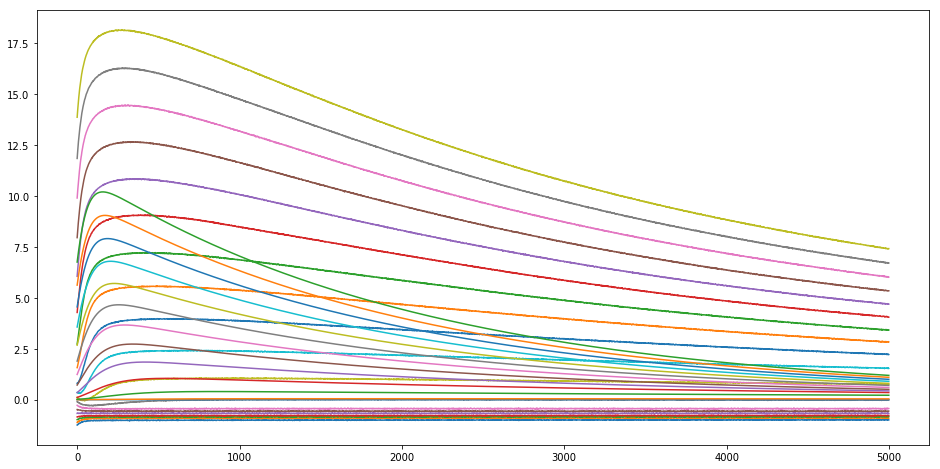

In [7]:
plt.figure(figsize=(16,8))
for I,V in zip(ana[5].rec.current, median_voltages):
    plt.plot(I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot] - ana[demo].params['I_leak'](V))
    
plt.gca().set_prop_cycle(None)

ret0 = None
#fits = []
for I,V in zip(ana[demo].rec.current[first_fitted:], median_voltages[first_fitted:]):
    U = V - ana[demo].params['E_K']
    p0 = [1.0e-1, 1.0e3, 1.0e-2, 1.0e3]
    ret1 = scipy.optimize.least_squares(lambda p, x, y: HH(x, U, p) - y,
                                        ret0.x,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.], [np.inf, np.inf, 1., np.inf])
                                       ) if ret0 else None
    ret0 = scipy.optimize.least_squares(lambda p, x, y: HH(x, U, p) - y,
                                        p0,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.], [np.inf, np.inf, 1., np.inf])
                                       )
    
    res = ret1.x if ret1 and ret1.cost < ret0.cost else ret0.x
    plt.plot(HH(t[:tplot], U, res))
    print res
    #fits.append((res, U))

[2.86956941e-04 1.94349072e+00 7.04298709e-03 3.69791779e+03]
[2.27486811e-03 2.31949532e+02 2.91074968e-01 1.58786687e+04]
[1.29328365e-02 1.93486513e+02 9.93692515e-02 5.74020932e+03]
[2.72479026e-02 1.41616022e+02 5.09535020e-02 3.59589546e+03]
[3.99080487e-02 1.14015390e+02 3.37684134e-02 2.84398709e+03]
[4.98998546e-02 9.69903965e+01 2.83084120e-02 2.52132558e+03]
[5.77719750e-02 8.52074215e+01 2.67280834e-02 2.36558063e+03]
[6.43542207e-02 7.65739684e+01 2.57773621e-02 2.27335571e+03]
[7.00536745e-02 6.98727258e+01 2.41529249e-02 2.21349160e+03]
[7.50627363e-02 6.45542600e+01 2.23039698e-02 2.17041397e+03]
[7.93566416e-02 6.01146357e+01 2.07496249e-02 2.13828750e+03]
[8.31055439e-02 5.63820625e+01 1.93143384e-02 2.11360939e+03]
[8.64085289e-02 5.32144629e+01 1.82862968e-02 2.08961734e+03]


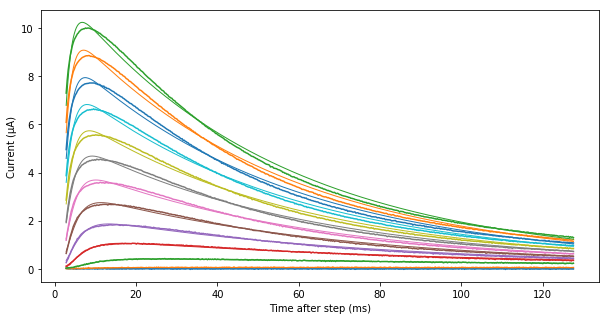

In [37]:
plt.figure(figsize=(10,5))
for I,V in zip(ana[demo].rec.current[first_fitted:], median_voltages[first_fitted:]):
    plt.plot(t[:tplot:10]*Kv14.tres, I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot:10] - ana[demo].params['I_leak'](V))
    
plt.gca().set_prop_cycle(None)

ret0 = None
#fits = []
for I,V in zip(ana[demo].rec.current[first_fitted:], median_voltages[first_fitted:]):
    U = V - ana[demo].params['E_K']
    p0 = [1.0e-1, 1.0e3, 1.0e-2, 1.0e3]
    ret1 = ah.bounded_LM_fit(lambda p, x, y: HH(x, U, p) - y,
                                        ret0.x,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.], [np.inf, np.inf, 1., np.inf])
                                       ) if ret0 else None
    ret0 = ah.bounded_LM_fit(lambda p, x, y: HH(x, U, p) - y,
                                        p0,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.], [np.inf, np.inf, 1., np.inf])
                                       )
    
    res = ret1.x if ret1 and ret1.cost < ret0.cost else ret0.x
    plt.plot(t[:tplot:10]*Kv14.tres, HH(t[:tplot:10], U, res), lw=1)
    print res
    #fits.append((res, U))
    
plt.ylabel(u'Current (µA)')
plt.xlabel('Time after step (ms)')
plt.savefig('/home/kernfel/Documents/Thesis/Models figures/Kv14-1comp-fit.svg')

In [12]:
print median_voltages[first_fitted:]

[-59.6619, -49.7131, -39.7339, -29.7852, -19.8364, -9.85718, 0.0915527, 10.0403, 20.05, 29.9988, 39.9475, 49.9268, 59.8755]


Neither of these fits look great, exactly... so let's try something else: Perhaps the model is too reductive. Could there be two components to it?
## Two components: One fast, one slow, both inactivating

In [17]:
# Some initial values from several iterations of trying to get a good fast & slow
fits_ext_p0 = [
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.42081465e-02, 3.80135749e+02, 6.38591759e-02, 4.87138978e+03, 4.53899075e-02, 9.91871948e+01, 1.04647195e-06, 1.46505568e+03],
    [1.73895186e-02, 2.84885303e+02, 6.61381567e-02, 4.68949830e+03, 5.17874316e-02, 7.48485617e+01, 1.45223442e-08, 1.44136454e+03],
    [1.73895186e-02, 2.74885303e+02, 6.41381567e-02, 4.69949830e+03, 5.57874316e-02, 7.08485617e+01, 1.45223442e-12, 1.44136454e+03],
    [1.73895186e-02, 2.64885303e+02, 6.21381567e-02, 4.70949830e+03, 6.17874316e-02, 6.68485617e+01, 1.45223442e-15, 1.44136454e+03],
    [1.73895186e-02, 2.54885303e+02, 6.01381567e-02, 4.72949830e+03, 6.57874316e-02, 6.28485617e+01, 1.45223442e-18, 1.44136454e+03],
    [1.73895186e-02, 2.44885303e+02, 5.81381567e-02, 4.74949830e+03, 7.17874316e-02, 5.88485617e+01, 1.45223442e-26, 1.44136454e+03],
    [1.75037140e-02, 2.29092127e+02, 5.51733567e-02, 4.78776232e+03, 7.55955872e-02, 5.43700416e+01, 5.21362349e-18, 1.44659691e+03],
    [1.72435134e-02, 2.13699825e+02, 5.23052040e-02, 4.88100112e+03, 7.89005902e-02, 5.06488733e+01, 2.67342944e-15, 1.46119205e+03],
    [1.66858504e-02, 1.97714913e+02, 5.16146762e-02, 4.98309796e+03, 8.17107281e-02, 4.74851633e+01, 9.26682489e-17, 1.48333106e+03]
]

In [9]:
def HH_ext(t, U, p):
    return U * ( p[0] * (1 - np.exp(-t/p[1]))**4 * (p[2] - (p[2]-1)*np.exp(-t/p[3])) \
               + p[4] * (1 - np.exp(-t/p[5]))**4 * (p[6] - (p[6]-1)*np.exp(-t/p[7])) )

[2.61167137e-04, 2.99822233e+01, 7.76972158e-03, 3.93297484e+03, 3.12626608e-02, 7.66411094e+01, 1.04799350e-07, 3.80898202e+01],  1.5511e+00
[2.52326863e-03, 1.39017363e+03, 1.86623775e-05, 6.51828263e+03, 5.56623452e-03, 3.31267901e+02, 1.65689503e-01, 8.35421016e+02],  1.6824e+00
[6.31905127e-03, 8.34593179e+02, 6.61498884e-06, 9.25943328e+03, 1.48887817e-02, 1.98778764e+02, 7.06365805e-02, 2.06825090e+03],  1.6164e+00
[6.51826105e-03, 4.59340894e+02, 4.69703656e-02, 9.28213601e+03, 2.74256636e-02, 1.38035533e+02, 2.34134301e-02, 2.20862463e+03],  1.6322e+00
[1.00711043e-02, 3.88353956e+02, 9.87830062e-02, 6.60727051e+03, 4.00882916e-02, 1.10168359e+02, 1.35663530e-36, 1.77156406e+03],  1.9393e+00
[1.27081547e-02, 3.37909260e+02, 8.65988414e-02, 5.47388313e+03, 4.92996142e-02, 9.20447392e+01, 7.32009730e-35, 1.59750503e+03],  2.2768e+00
[1.42906003e-02, 3.08827954e+02, 8.47516458e-02, 5.16326770e+03, 5.67965611e-02, 8.02610153e+01, 1.41346826e-05, 1.52130007e+03],  2.8326e+00
[1.569

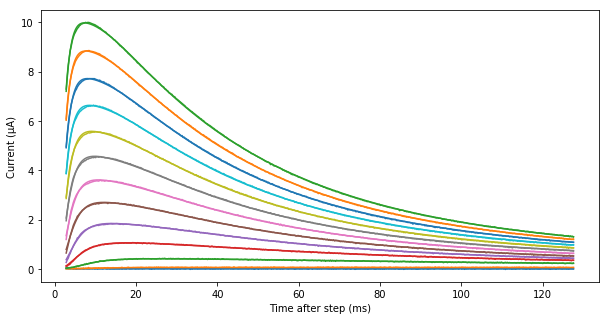

In [35]:
median_voltages = [np.median(V[Kv14.rec_limits[0]:Kv14.rec_limits[1]]) for V in ana[demo].rec.voltage]
t = np.arange(Kv14.rec_limits[1] - Kv14.rec_limits[0]) + Kv14.rec_limits[0] - Kv14.rec_step_t0

plt.figure(figsize=(10,5))
for I,V in zip(ana[demo].rec.current[first_fitted:], median_voltages[first_fitted:]):
    plt.plot(t[:tplot:10]*Kv14.tres, I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot:10] - ana[demo].params['I_leak'](V))
plt.gca().set_prop_cycle(None)

ret0 = None
fits_ext = []
cost = 0
for I,V,p0 in zip(ana[demo].rec.current[first_fitted:], median_voltages[first_fitted:], fits_ext_p0):
    U = V - ana[demo].params['E_K']
    ret1 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                        ret0.x,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                  [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                       ) if ret0 else None
    ret0 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                        p0,
                                        args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - ana[demo].params['I_leak'](V)),
                                        bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                  [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                       )
    
    ret = ret1 if ret1 and ret1.cost < ret0.cost else ret0
    plt.plot(t[:tplot:10]*Kv14.tres, HH_ext(t[:tplot:10], U, ret.x))
    print "[%.8e, %.8e, %.8e, %.8e, %.8e, %.8e, %.8e, %.8e],  %.4e" % tuple(ret.x.tolist() + [ret.cost])
    fits_ext.append((ret.x, U))
    cost += ret.cost
print cost

plt.ylabel(u'Current (µA)')
plt.xlabel('Time after step (ms)')
plt.savefig('/home/kernfel/Documents/Thesis/Models figures/Kv14-2comp-fit.svg')

As in the Kv2.1 case, it seems to be possible to separate into two currents quite cleanly...

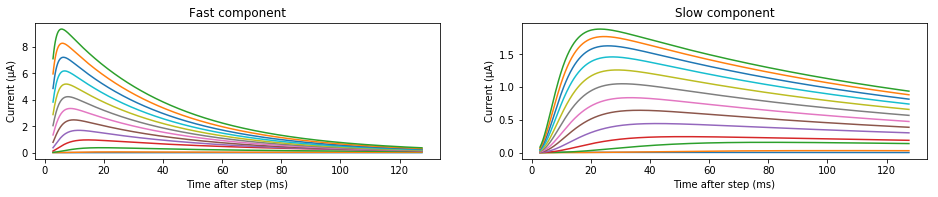

In [76]:
plt.figure(figsize=(16,2.5))
plt.subplot(1,2,2).set_title('Slow component')
plt.ylabel(u'Current (µA)')
plt.xlabel('Time after step (ms)')
for p, U in fits_ext:
    plt.plot(t[:tplot:10]*Kv14.tres, U * (p[0] * (1 - np.exp(-t[:tplot:10]/p[1]))**4 * (p[2] - (p[2]-1)*np.exp(-t[:tplot:10]/p[3]))))
    
plt.subplot(1,2,1).set_title('Fast component')
plt.ylabel(u'Current (µA)')
plt.xlabel('Time after step (ms)')
for p, U in fits_ext:
    plt.plot(t[:tplot:10]*Kv14.tres, U * (p[4] * (1 - np.exp(-t[:tplot:10]/p[5]))**4 * (p[6] - (p[6]-1)*np.exp(-t[:tplot:10]/p[7]))))

plt.savefig('/home/kernfel/Documents/Thesis/Models figures/Kv14_component_split.svg')

## Fitting all recordings
Single-component style first, to see if that's appropriate.

0
0
0
0
0
0
0
0
0
0
0
0
0
0 1180.8571149608695
1
1
1
1
1
1
1
1
1
1
1
1
1
1 564.4593868156073
2
2
2
2
2
2
2
2
2
2
2
2
2
2 70.51101625211358
3
3
3
3
3
3
3
3
3
3
3
3
3
3 730.4836297032803
4
4
4
4
4
4
4
4
4
4
4
4
4
4 685.0204179131546
5
5
5
5
5
5
5
5
5
5
5
5
5
5 1379.3762728696634
6
6
6
6
6
6
6
6
6
6
6
6
6
6 945.2920751971974
7
7
7
7
7
7
7
7
7
7
7
7
7
7 753.5196694859869
8
8
8
8
8
8
8
8
8
8
8
8
8
8 122.37012318925555
9
9
9
9
9
9
9
9
9
9
9
9
9
9 195.00113702478714
10
10
10
10
10
10
10
10
10
10
10
10
10
10 1065.710085188565
11
11
11
11
11
11
11
11
11
11
11
11
11
11 233.96389693810374
12
12
12
12
12
12
12
12
12
12
12
12
12
12 425.49715267143205
13
13
13
13
13
13
13
13
13
13
13
13
13
13 814.1547537698589
654.729766569991 393.78155355056737


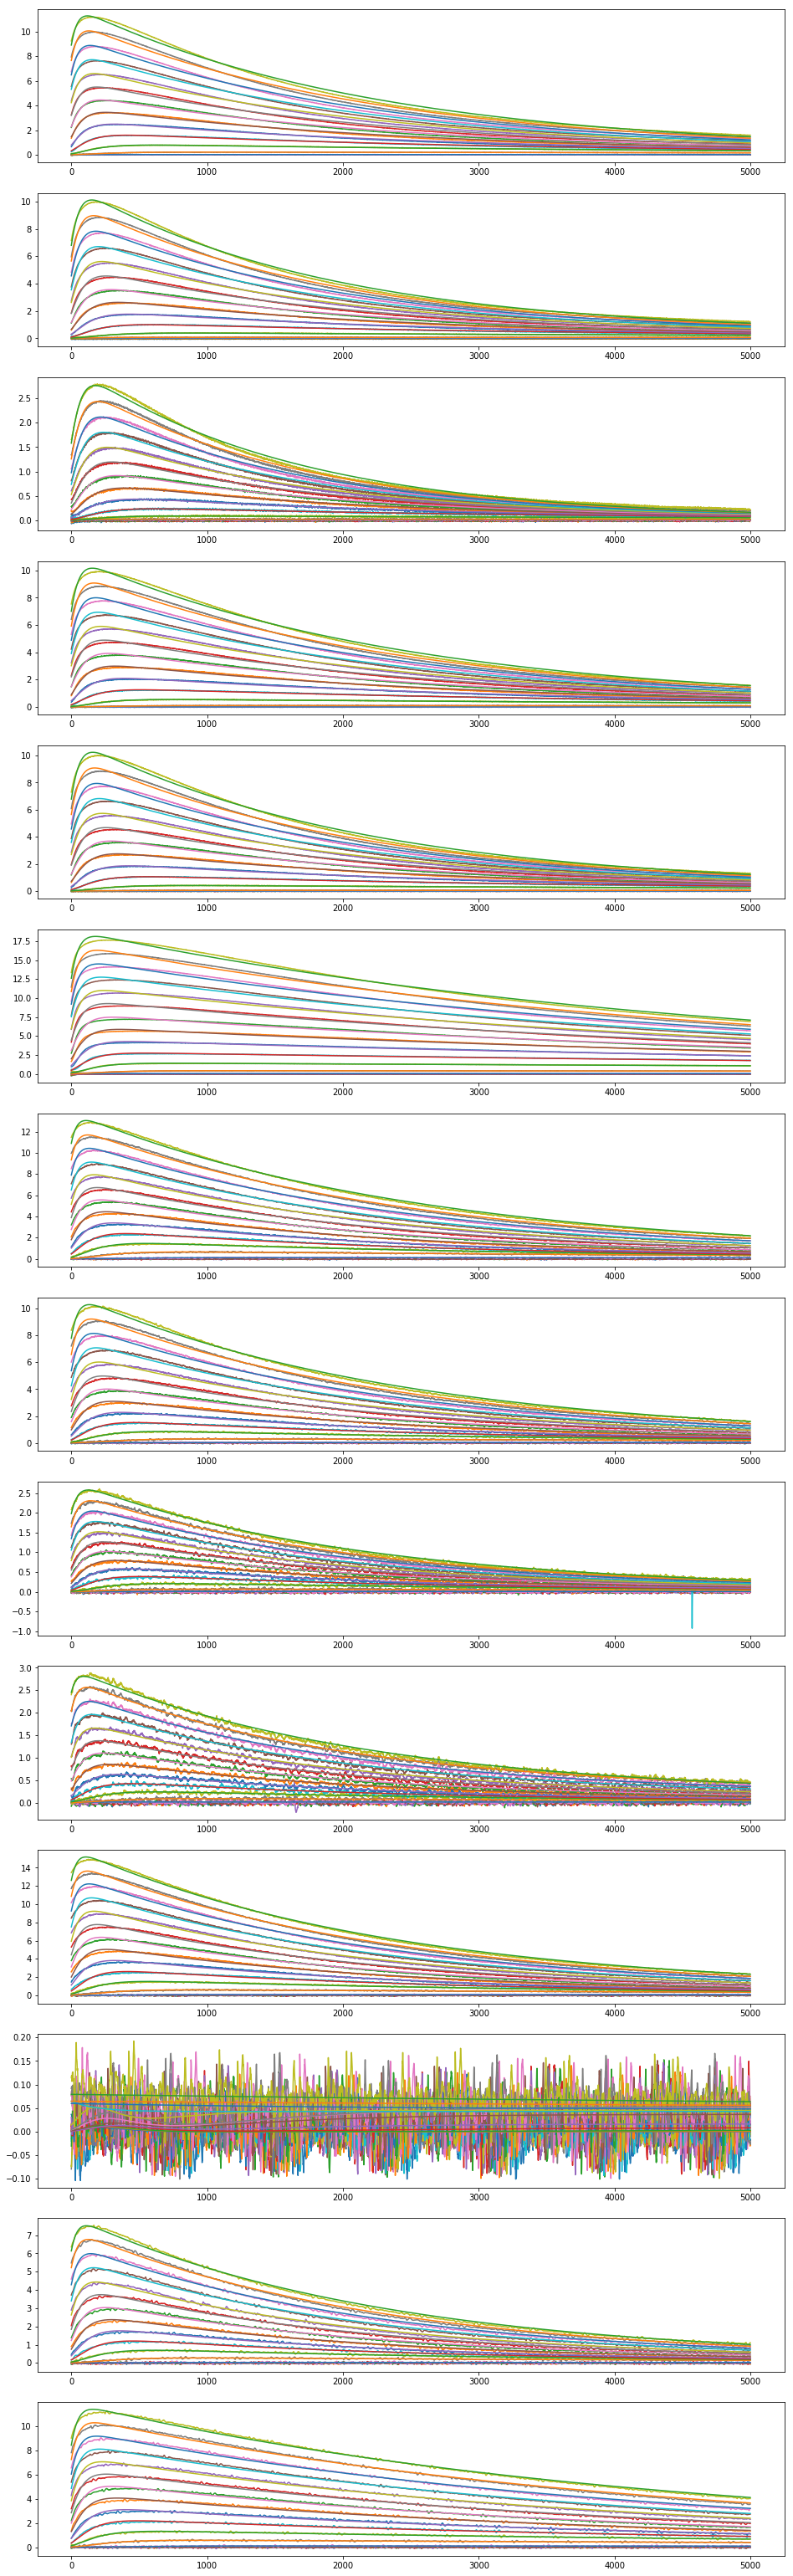

In [18]:
t = np.arange(Kv14.rec_limits[1] - Kv14.rec_limits[0]) + Kv14.rec_limits[0] - Kv14.rec_step_t0
plt.figure(figsize=(16,4*len(ana)))

p0_single = [
    [2.37123027e-03, 1.44579839e+02, 7.87454167e-01, 6.08021990e+03],
    [2.37123027e-03, 1.44579839e+02, 7.87454167e-01, 6.08021990e+03],
    [2.37123027e-03, 1.44579839e+02, 7.87454167e-01, 6.08021990e+03],
    [2.37123027e-03, 1.44579839e+02, 5.87454167e-01, 4.08021990e+03],
    [2.37123027e-03, 1.44579839e+02, 4.87454167e-01, 3.18021990e+03],
    [3.17565932e-03, 1.19447746e+02, 3.00403220e-01, 2.59535262e+03],
    [3.91143419e-03, 1.01973467e+02, 1.38772250e-01, 1.69963462e+03],
    [4.97275812e-03, 9.43900424e+01, 1.78080623e-01, 1.39477886e+03],
    [5.98527812e-03, 8.74002500e+01, 2.02008686e-01, 1.24104354e+03],
    [6.92851359e-03, 7.97630922e+01, 2.35234929e-01, 1.13504888e+03],
    [7.84329810e-03, 7.39463791e+01, 2.72798857e-01, 1.02342500e+03],
    [8.62886755e-03, 6.75487979e+01, 3.11013534e-01, 9.76700841e+02],
    [9.30694750e-03, 6.11089009e+01, 3.56630488e-01, 9.78822527e+02]
]

allfits = [None]*len(ana)
costs1 = [0] * len(ana)
for i,a in enumerate(ana):
    median_voltages = [np.median(V[Kv14.rec_limits[0]:Kv14.rec_limits[1]]) for V in a.rec.voltage]

    plt.subplot(len(ana), 1, i + 1)
    for I,V in zip(a.rec.current, median_voltages):
        plt.plot(I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot] - a.params['I_leak'](V))
    plt.gca().set_prop_cycle(None)

    ret0 = None
    f = []
    cost = 0
    for I,V,p0 in zip(a.rec.current[first_fitted:], median_voltages[first_fitted:], p0_single):
        U = V - a.params['E_K']
        ret1 = scipy.optimize.least_squares(lambda p, x, y: HH(x, U, p) - y,
                                            ret0.x,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf])
                                           ) if ret0 else None
        ret0 = scipy.optimize.least_squares(lambda p, x, y: HH(x, U, p) - y,
                                            p0,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf])
                                           )

        ret = ret1 if ret1 and ret1.cost < ret0.cost else ret0
        plt.plot(HH(t[:tplot], U, ret.x))
#         print "[%.8e, %.8e, %.8e, %.8e, %.8e, %.8e],  %.4e" % tuple(ret.x.tolist() + [ret.cost])
        f.append((ret, U))
        cost += ret.cost
        print i
    
    print i, cost
    allfits[i] = f
    costs1[i] = cost
print np.mean(costs1), np.std(costs1)

I'd say there's only a single recording (third from the top) that fits reasonably well. Let's try to fit all with two components:

0
0
0
0
0
0
0
0
0
0
0
0
0
0 19.886356253051705
1
1
1
1
1
1
1
1
1
1
1
1
1
1 21.647336717310875
2
2
2
2
2
2
2
2
2
2
2
2
2
2 19.7686413815335
3
3
3
3
3
3
3
3
3
3
3
3
3
3 27.637156178979758
4
4
4
4
4
4
4
4
4
4
4
4
4
4 33.72286576528609
5
5
5
5
5
5
5
5
5
5
5
5
5
5 549.5927827787879
6
6
6
6
6
6
6
6
6
6
6
6
6
6 131.55661191065073
7
7
7
7
7
7
7
7
7
7
7
7
7
7 134.28095438927988
8
8
8
8
8
8
8
8
8
8
8
8
8
8 91.71502118514522
9
9
9
9
9
9
9
9
9
9
9
9
9
9 167.87431639737227
10
10
10
10
10
10
10
10
10
10
10
10
10
10 184.63056860476516
11
11
11
11
11
11
11
11
11
11
11
11
11
11 232.49150517820178
12
12
12
12
12
12
12
12
12
12
12
12
12
12 125.17363035741226
13
13
13
13
13
13
13
13
13
13
13
13
13
13 222.9934126574076
140.2122256967989 135.077433861508


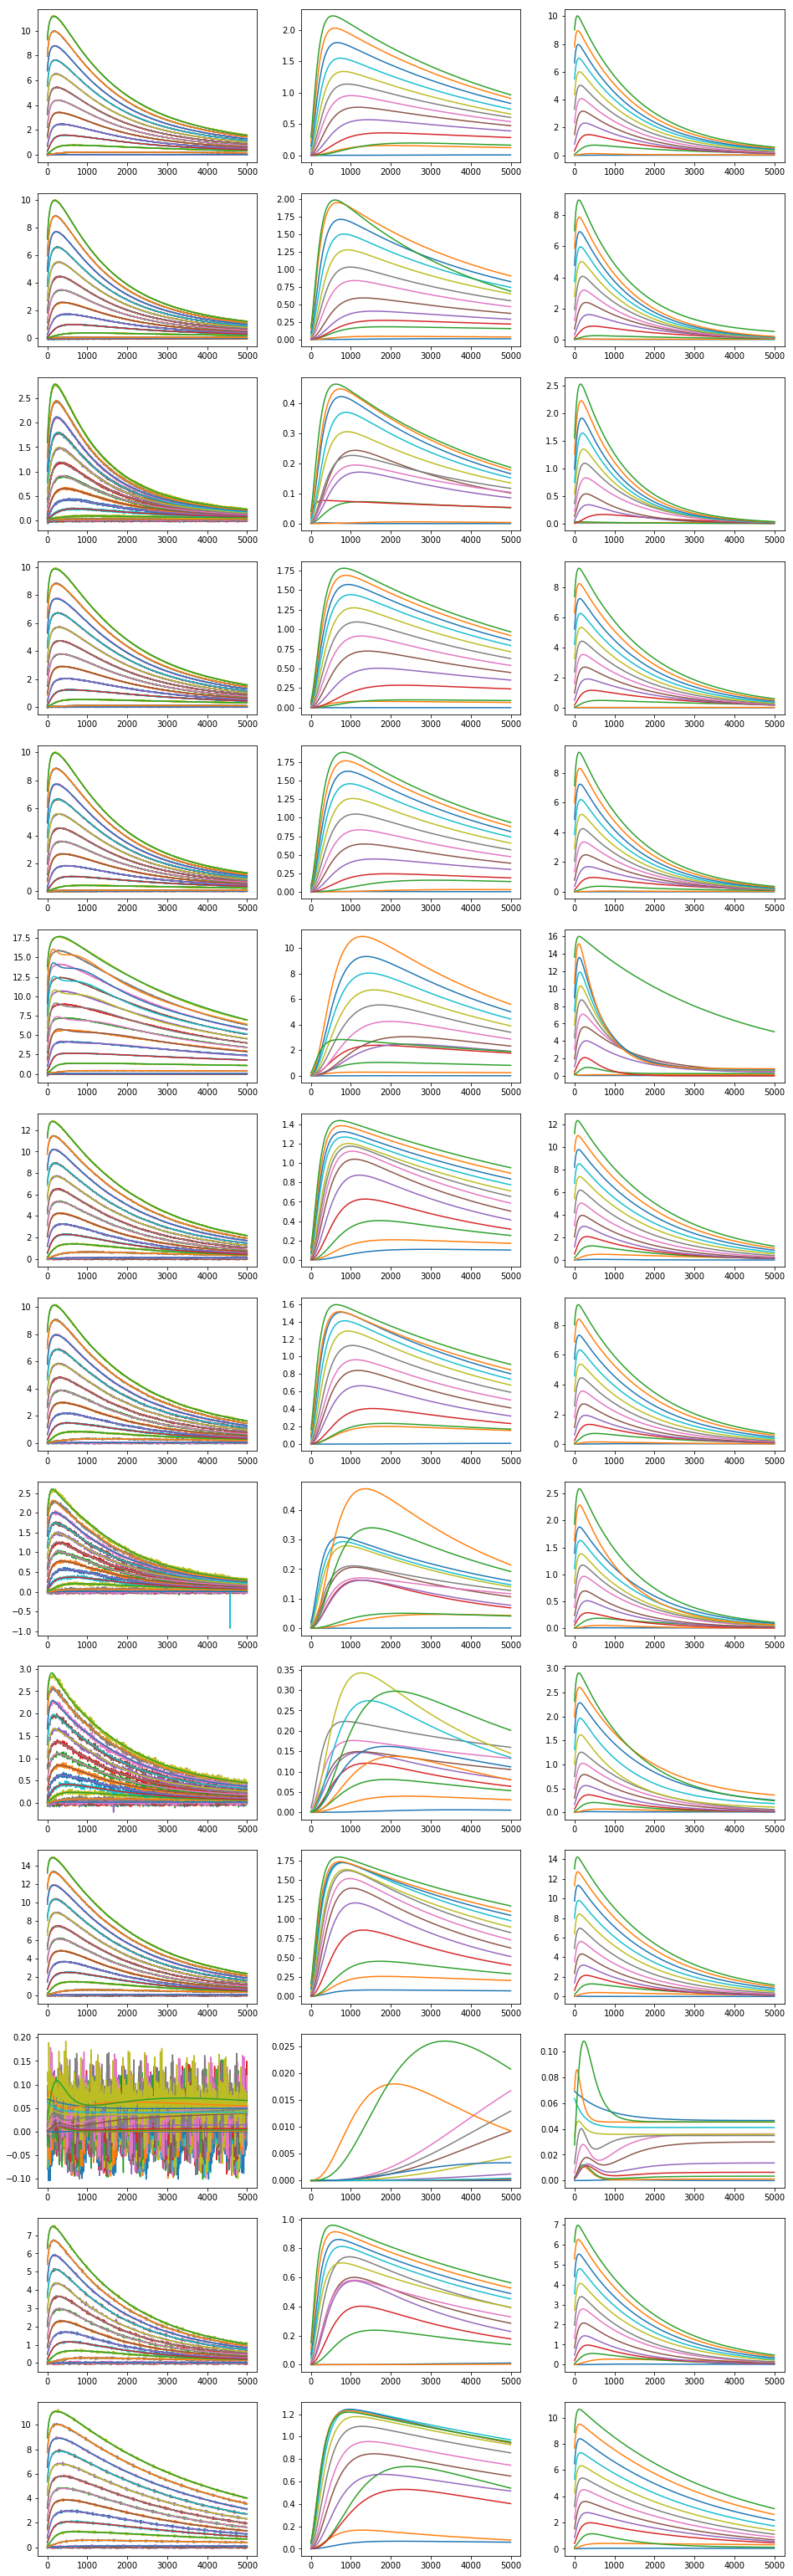

In [19]:
t = np.arange(Kv14.rec_limits[1] - Kv14.rec_limits[0]) + Kv14.rec_limits[0] - Kv14.rec_step_t0
plt.figure(figsize=(16,4*len(ana)))

allfits_ext = [None]*len(ana)

costs2 = [0]*len(ana)
for i,a in enumerate(ana):
    median_voltages = [np.median(V[Kv14.rec_limits[0]:Kv14.rec_limits[1]]) for V in a.rec.voltage]

    plt.subplot(len(ana), 3, 3*i + 1)
    for I,V in zip(a.rec.current, median_voltages):
        plt.plot(I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot] - a.params['I_leak'](V))
    plt.gca().set_prop_cycle(None)

    ret0 = None
    f = []
    cost = 0
    for I,V,p0 in zip(a.rec.current[first_fitted:], median_voltages[first_fitted:], fits_ext_p0):
        U = V - a.params['E_K']
        ret1 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                            ret0.x,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                           ) if ret0 else None
        ret0 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                            p0,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                           )

        ret = ret1 if ret1 and ret1.cost < ret0.cost else ret0
        plt.plot(HH_ext(t[:tplot], U, ret.x))
#         print "[%.8e, %.8e, %.8e, %.8e, %.8e, %.8e],  %.4e" % tuple(ret.x.tolist() + [ret.cost])
        f.append((ret, U))
        cost += ret.cost
        print i
    
    print i, cost
    allfits_ext[i] = f
    costs2[i] = cost
    
    plt.subplot(len(ana), 3, 3*i + 2)
    for p, U in f:
        plt.plot(U * (p.x[0] * (1 - np.exp(-t[:tplot]/p.x[1]))**4 * (p.x[2] - (p.x[2]-1)*np.exp(-t[:tplot]/p.x[3]))))

    plt.subplot(len(ana), 3, 3*i + 3)
    for p, U in f:
        plt.plot(U * (p.x[4] * (1 - np.exp(-t[:tplot]/p.x[5]))**4 * (p.x[6] - (p.x[6]-1)*np.exp(-t[:tplot]/p.x[7]))))
        
print np.mean(costs2), np.std(costs2)

In [23]:
import scipy.stats
tt, p = scipy.stats.ttest_rel(costs1, costs2)
print tt,p
print len(costs1)

5.16098637042796 0.0001831262284343778
14


In [24]:
costs1_mse = np.sqrt(np.array(costs1)/len(t))
costs2_mse = np.sqrt(np.array(costs2)/len(t))
print np.mean(costs1_mse), np.std(costs1_mse)
print np.mean(costs2_mse), np.std(costs2_mse)
tt_mse, p_mse = scipy.stats.ttest_rel(costs1_mse, costs2_mse)
print tt_mse, p_mse

0.12080085234133539 0.043339856595370596
0.05324298236665607 0.026316086687813746
5.542238830621413 9.508744944735443e-05


Very nice fits overall, but the split needs some attention. So, again: Individual fitting, go!

In [39]:
def fit_single(a, fit_p0, first = first_fitted, last = 19):
    t = np.arange(Kv14.rec_limits[1] - Kv14.rec_limits[0]) + Kv14.rec_limits[0] - Kv14.rec_step_t0
    plt.figure(figsize=(16,8))

    median_voltages = [np.median(V[Kv14.rec_limits[0]:Kv14.rec_limits[1]]) for V in a.rec.voltage]

    plt.subplot(1,3,1)
    for I,V in zip(a.rec.current, median_voltages):
        plt.plot(I[Kv14.rec_limits[0]:Kv14.rec_limits[0]+tplot] - a.params['I_leak'](V))
    plt.gca().set_prop_cycle(None)

    ret0 = None
    f = []
    cost = 0
    for I,V,p0 in zip(a.rec.current[first:last], median_voltages[first:last], fit_p0):
        U = V - a.params['E_K']
        ret1 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                            ret0.x,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                           ) if ret0 else None
        ret0 = scipy.optimize.least_squares(lambda p, x, y: HH_ext(x, U, p) - y,
                                            p0,
                                            args = (t, I[Kv14.rec_limits[0]:Kv14.rec_limits[1]] - a.params['I_leak'](V)),
                                            bounds = ([0.,0.,0.,0.,0.,0.,0.,0.],
                                                      [np.inf, np.inf, 1., np.inf, np.inf, np.inf, 1., np.inf])
                                           )

        ret = ret1 if ret1 and ret1.cost < ret0.cost else ret0
        plt.plot(HH_ext(t[:tplot], U, ret.x))
        print "[%.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e],  %.4e" % tuple(ret.x.tolist() + [ret.cost])
        f.append((ret, U))
        cost += ret.cost

    plt.subplot(1,3,2)
    for p, U in f:
        plt.plot(U * (p.x[0] * (1 - np.exp(-t[:tplot]/p.x[1]))**4 * (p.x[2] - (p.x[2]-1)*np.exp(-t[:tplot]/p.x[3]))))

    plt.subplot(1,3,3)
    for p, U in f:
        plt.plot(U * (p.x[4] * (1 - np.exp(-t[:tplot]/p.x[5]))**4 * (p.x[6] - (p.x[6]-1)*np.exp(-t[:tplot]/p.x[7]))))
        
    return f, cost

In [53]:
costs3 = [0]*6

[4.8002e-04, 4.5282e+02, 3.0736e-03, 1.4619e+04, 6.8541e-04, 1.0539e+00, 7.6412e-01, 4.0455e+02],  6.6578e-01
[6.9270e-03, 1.7666e+02, 4.0383e-10, 9.4948e+03, 1.9663e-03, 4.5564e+02, 6.5433e-01, 6.2677e+01],  7.1017e-01
[4.6418e-03, 5.2533e+02, 7.6881e-03, 1.3450e+04, 2.3330e-02, 1.4104e+02, 4.9984e-02, 2.8689e+03],  6.7281e-01
[8.8927e-03, 4.2269e+02, 1.3067e-01, 9.4493e+03, 4.0393e-02, 1.0945e+02, 9.9902e-24, 1.8591e+03],  8.7320e-01
[1.1956e-02, 3.3888e+02, 9.9018e-02, 7.2079e+03, 5.1801e-02, 8.7415e+01, 4.8934e-20, 1.5644e+03],  1.0049e+00
[1.3726e-02, 2.8013e+02, 7.7160e-02, 6.3959e+03, 5.8926e-02, 7.2232e+01, 2.8016e-03, 1.4901e+03],  1.0198e+00
[1.4765e-02, 2.4036e+02, 4.6965e-02, 6.0270e+03, 6.4357e-02, 6.2281e+01, 8.8826e-03, 1.4678e+03],  1.0341e+00
[1.5545e-02, 2.1683e+02, 2.7425e-02, 5.8296e+03, 6.9101e-02, 5.5333e+01, 1.2567e-02, 1.4677e+03],  1.0669e+00
[1.6353e-02, 1.9500e+02, 7.3576e-22, 5.6330e+03, 7.2904e-02, 4.9782e+01, 1.8056e-02, 1.4655e+03],  1.2910e+00
[1.7066e-0

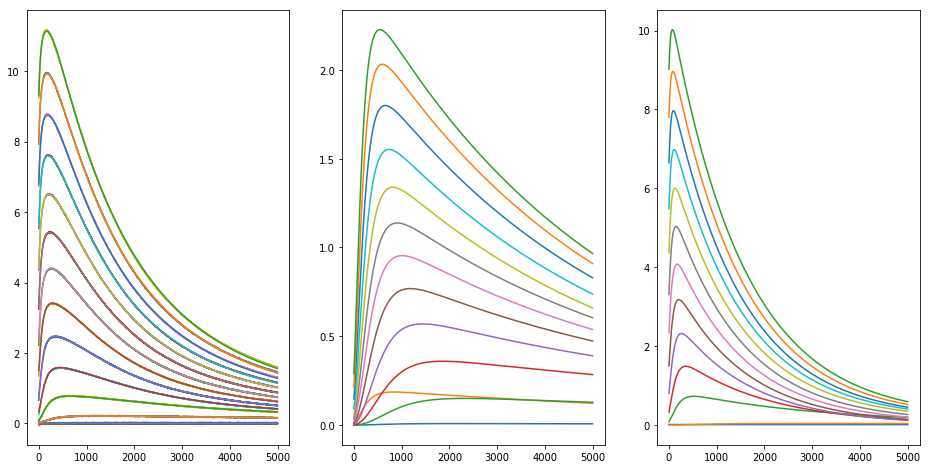

In [54]:
p0 = [
    [1.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [3.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.42081465e-02, 3.80135749e+02, 6.38591759e-02, 4.87138978e+03, 4.53899075e-02, 9.91871948e+01, 1.04647195e-06, 1.46505568e+03],
    [1.73895186e-02, 2.84885303e+02, 6.61381567e-02, 4.68949830e+03, 5.17874316e-02, 7.48485617e+01, 1.45223442e-08, 1.44136454e+03],
    [1.73895186e-02, 2.74885303e+02, 6.41381567e-02, 4.69949830e+03, 5.57874316e-02, 7.08485617e+01, 1.45223442e-12, 1.44136454e+03],
    [1.73895186e-02, 2.64885303e+02, 6.21381567e-02, 4.70949830e+03, 6.17874316e-02, 6.68485617e+01, 1.45223442e-15, 1.44136454e+03],
    [1.73895186e-02, 2.54885303e+02, 6.01381567e-02, 4.72949830e+03, 6.57874316e-02, 6.28485617e+01, 1.45223442e-18, 1.44136454e+03],
    [1.73895186e-02, 2.44885303e+02, 5.81381567e-02, 4.74949830e+03, 7.17874316e-02, 5.88485617e+01, 1.45223442e-26, 1.44136454e+03],
    [1.75037140e-02, 2.29092127e+02, 5.51733567e-02, 4.78776232e+03, 7.55955872e-02, 5.43700416e+01, 5.21362349e-18, 1.44659691e+03],
    [1.72435134e-02, 2.13699825e+02, 5.23052040e-02, 4.88100112e+03, 7.89005902e-02, 5.06488733e+01, 2.67342944e-15, 1.46119205e+03],
    [1.66858504e-02, 1.97714913e+02, 5.16146762e-02, 4.98309796e+03, 8.17107281e-02, 4.74851633e+01, 9.26682489e-17, 1.48333106e+03]
]
allfits_ext[0], cost = fit_single(ana[0], p0)
print cost
costs3[0] = cost

[1.6237e-03, 1.4748e+03, 4.6592e-04, 5.7396e+03, 2.5766e-03, 6.9462e+01, 3.5071e-01, 9.5481e+02],  1.1642e+00
[2.0336e-03, 3.0141e+02, 3.0369e-07, 1.6991e+04, 2.1801e-03, 2.5909e+01, 4.7585e-01, 3.1961e+02],  1.1443e+00
[5.7237e-03, 3.7872e+02, 2.2363e-01, 1.2602e+04, 9.3247e-03, 1.5105e+02, 9.8082e-10, 3.0900e+03],  1.1664e+00
[7.1671e-03, 4.0450e+02, 1.8691e-01, 9.4803e+03, 2.6708e-02, 1.4087e+02, 9.2835e-29, 2.0561e+03],  1.2329e+00
[9.1646e-03, 3.7045e+02, 1.5894e-01, 6.9122e+03, 4.0899e-02, 1.1661e+02, 2.1149e-05, 1.6663e+03],  1.6178e+00
[1.1682e-02, 3.2239e+02, 1.3604e-01, 5.5673e+03, 5.0621e-02, 9.7390e+01, 3.7848e-05, 1.4820e+03],  2.0266e+00
[1.4370e-02, 2.7238e+02, 1.2180e-01, 4.8373e+03, 5.7116e-02, 8.2639e+01, 4.6707e-06, 1.3824e+03],  2.3169e+00
[1.5339e-02, 2.4233e+02, 1.2230e-01, 4.7075e+03, 6.2949e-02, 7.2683e+01, 5.2725e-06, 1.3601e+03],  2.3425e+00
[1.6989e-02, 2.2791e+02, 1.1733e-01, 4.4908e+03, 6.8340e-02, 6.5100e+01, 1.6034e-22, 1.3182e+03],  2.1308e+00
[1.7789e-0

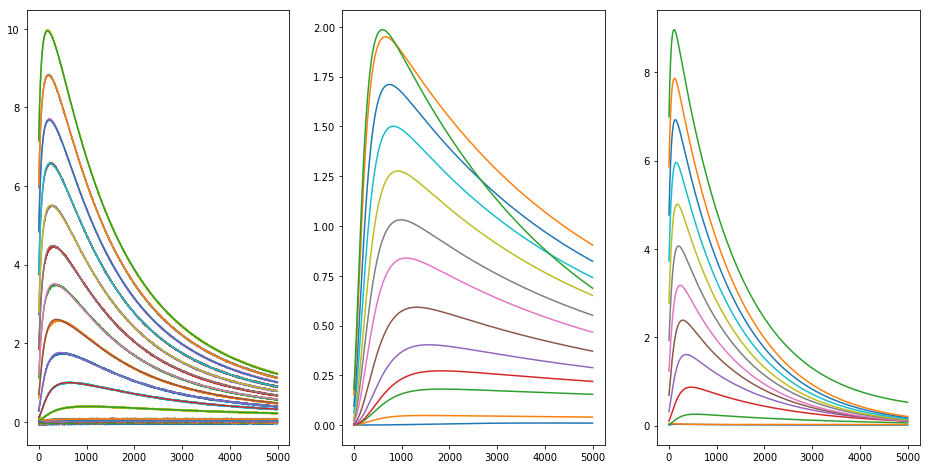

In [55]:
p0 = [
    [6.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [6.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [6.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.42081465e-02, 3.80135749e+02, 6.38591759e-02, 4.87138978e+03, 4.53899075e-02, 9.91871948e+01, 1.04647195e-06, 1.46505568e+03],
    [1.73895186e-02, 2.84885303e+02, 6.61381567e-02, 4.68949830e+03, 5.17874316e-02, 7.48485617e+01, 1.45223442e-08, 1.44136454e+03],
    [1.73895186e-02, 2.74885303e+02, 6.41381567e-02, 4.69949830e+03, 5.57874316e-02, 7.08485617e+01, 1.45223442e-12, 1.44136454e+03],
    [1.73895186e-02, 2.64885303e+02, 6.21381567e-02, 4.70949830e+03, 6.17874316e-02, 6.68485617e+01, 1.45223442e-15, 1.44136454e+03],
    [1.73895186e-02, 2.54885303e+02, 6.01381567e-02, 4.72949830e+03, 6.57874316e-02, 6.28485617e+01, 1.45223442e-18, 1.44136454e+03],
    [1.73895186e-02, 2.44885303e+02, 5.81381567e-02, 4.74949830e+03, 7.17874316e-02, 5.88485617e+01, 1.45223442e-26, 1.44136454e+03],
    [1.75037140e-02, 2.29092127e+02, 5.51733567e-02, 4.78776232e+03, 7.55955872e-02, 5.43700416e+01, 5.21362349e-18, 1.44659691e+03],
    [1.72435134e-02, 2.13699825e+02, 5.23052040e-02, 4.88100112e+03, 7.89005902e-02, 5.06488733e+01, 2.67342944e-15, 1.46119205e+03],
    [1.8035e-02, 1.6802e+02, 1.3165e-02, 1.3123e+03, 7.7004e-02, 5.0143e+01, 1.8661e-20, 3.9464e+03]
]
allfits_ext[1], cost = fit_single(ana[1], p0)
print cost
costs3[1] = cost

[1.2180e+01, 4.7597e+05, 6.6331e-03, 6.9969e+02, 1.4927e-03, 2.9209e+00, 4.1576e-01, 3.0771e-01],  1.3380e+00
[2.2651e-04, 2.8261e+02, 1.3610e-04, 7.1206e+03, 4.4503e-01, 3.3138e-01, 1.2731e-03, 1.9591e+01],  1.3406e+00
[1.8263e-03, 3.1389e+02, 2.8713e-01, 7.1412e+03, 1.1392e-03, 7.3401e+01, 4.4914e-06, 2.0409e+03],  1.3944e+00
[2.0129e-03, 3.7625e+02, 2.1302e-01, 6.5319e+03, 5.3112e-03, 1.4742e+02, 2.9617e-05, 1.7860e+03],  1.3644e+00
[3.7542e-03, 3.3684e+02, 1.0121e-01, 3.9644e+03, 8.7208e-03, 1.2395e+02, 1.7124e-04, 1.2371e+03],  1.5383e+00
[3.0543e-03, 3.1663e+02, 1.1583e-01, 4.4147e+03, 1.2114e-02, 1.1374e+02, 3.9154e-31, 1.3151e+03],  1.4680e+00
[2.5466e-03, 2.4915e+02, 1.3791e-01, 5.2624e+03, 1.4395e-02, 1.0135e+02, 2.2518e-04, 1.3531e+03],  1.5718e+00
[2.8961e-03, 2.7098e+02, 1.1738e-01, 4.8632e+03, 1.7207e-02, 9.2937e+01, 7.9684e-30, 1.2560e+03],  1.6007e+00
[3.6005e-03, 2.7426e+02, 8.2259e-02, 4.2475e+03, 1.9469e-02, 8.4621e+01, 1.2872e-04, 1.1585e+03],  1.5908e+00
[4.2847e-0

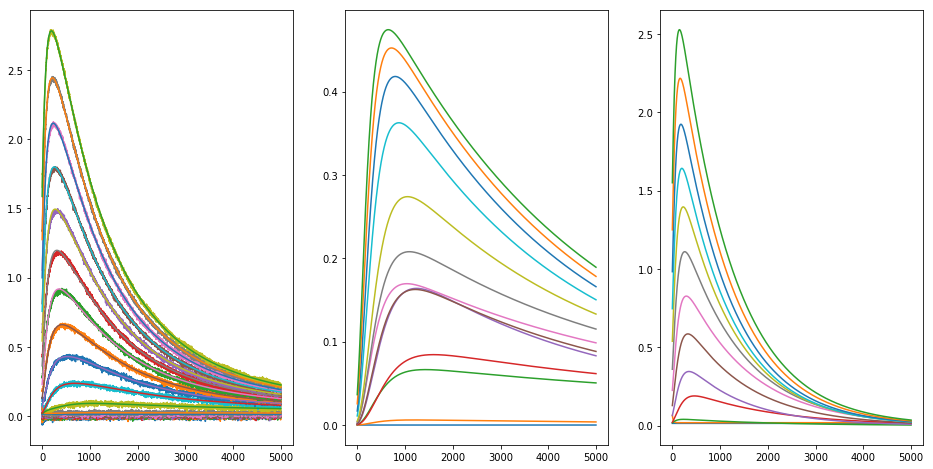

In [56]:
p0 = [
    [1.3140e-08, 2.2719e+04, 1.8343e-20, 5.4145e+00, 8.3185e-07, 1.6742e+04, 2.1029e-14, 3.0771e-01],
    [1.8885e-03, 8.8682e+02, 2.2475e-05, 1.0458e+04, 2.4923e-03, 2.5537e+02, 2.2039e-02, 1.2926e+03],
    [2.2786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 6.0308e-03, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [2.0882e-03, 4.2823e+02, 4.3578e-02, 9.3862e+03, 1.0825e-02, 1.1221e+02, 3.1857e-29, 1.8764e+03],
    [4.9414e-03, 3.6136e+02, 2.1389e-35, 3.9617e+03, 1.0035e-02, 3.0108e+02, 7.8946e-38, 1.0261e+03],
    [5.0414e-03, 3.2136e+02, 2.1389e-35, 3.2617e+03, 1.2035e-02, 2.0108e+02, 7.8946e-38, 1.0261e+03],
    [3.5652e-03, 2.4234e+02, 3.6695e-02, 6.0156e+03, 1.7806e-02, 6.2840e+01, 1.3951e-20, 1.4659e+03],
    [3.8476e-03, 2.1777e+02, 2.2186e-02, 5.8269e+03, 1.8491e-02, 5.5700e+01, 3.4986e-03, 1.4670e+03],
    [4.0330e-03, 1.9504e+02, 5.5298e-18, 5.6382e+03, 2.0223e-02, 5.0004e+01, 8.5453e-03, 1.4661e+03],
    [4.3048e-03, 1.7489e+02, 1.3271e-17, 5.5011e+03, 2.1416e-02, 4.5468e+01, 8.5272e-03, 1.4818e+03],
    [4.4947e-03, 1.5633e+02, 5.7562e-19, 5.4025e+03, 2.2217e-02, 4.1540e+01, 8.2158e-03, 1.4855e+03],
    [4.5359e-03, 1.4154e+02, 5.3694e-19, 5.3021e+03, 2.3634e-02, 3.8512e+01, 7.9238e-03, 1.5139e+03],
    [4.5535e-03, 1.2990e+02, 8.9734e-18, 5.1781e+03, 2.1876e-02, 3.5929e+01, 8.1433e-03, 1.5339e+03]
]
allfits_ext[2], cost = fit_single(ana[2], p0)
print cost
costs3[2] = cost

In [57]:
#### For 2017_12_06_{65-69}, which just doesn't fucking want to fit into the mould....
#### even when given a very, VERY close hand-fitted approximation.
#### Discarding it because it's a low-expression outlier anyway.
# p0 = [
#     [3.3e-3, 1e2, 3.3e-1, 1.4e3,
#       6.6e-3, 4e1, 3.3e-1, 0.7e3]
# ]
# allfits[3], cost = fit_single(ana[3], p0, 18)
# print cost


# p0 = [3.3e-3, 1e2, 3.3e-1, 1.4e3,
#       6.6e-3, 4e1, 3.3e-1, 0.7e3]

# plt.subplot(1,3,1)
# plt.plot(HH_ext(t[:tplot], U, p0))

# plt.subplot(1,3,2)
# plt.plot(allfits[3][-1][1] * (p0[0] * (1 - np.exp(-t[:tplot]/p0[1]))**4 * (p0[2] - (p0[2]-1)*np.exp(-t[:tplot]/p0[3]))))

# plt.subplot(1,3,3)
# plt.plot(allfits[3][-1][1] * (p0[4] * (1 - np.exp(-t[:tplot]/p0[5]))**4 * (p0[6] - (p0[6]-1)*np.exp(-t[:tplot]/p0[7]))))

[1.2562e-34, 2.3000e+04, 4.5003e-01, 1.7968e+01, 6.6163e-04, 2.8967e+00, 4.3057e-01, 3.0771e-01],  1.3817e+00
[3.4297e-03, 2.8770e+02, 6.2712e-02, 1.4647e+04, 1.9321e-03, 1.0202e+00, 4.0047e-01, 1.1104e+00],  1.3790e+00
[6.5029e-03, 1.0009e+03, 1.3278e-02, 1.1264e+04, 1.9266e-02, 1.7678e+02, 5.3115e-02, 2.8360e+03],  1.5189e+00
[6.4067e-03, 4.9522e+02, 1.4168e-01, 1.1981e+04, 3.2407e-02, 1.2496e+02, 7.5498e-05, 2.6528e+03],  1.6173e+00
[1.2933e-02, 4.3088e+02, 8.2358e-02, 6.5016e+03, 4.5063e-02, 1.0048e+02, 1.8416e-04, 1.8380e+03],  1.9689e+00
[1.4491e-02, 3.5464e+02, 7.6610e-02, 5.8848e+03, 5.2858e-02, 8.3793e+01, 1.6935e-33, 1.7299e+03],  2.0530e+00
[1.5671e-02, 3.1228e+02, 7.5396e-02, 5.6238e+03, 5.8927e-02, 7.2801e+01, 6.4005e-19, 1.6750e+03],  2.1205e+00
[1.6279e-02, 2.8334e+02, 7.4386e-02, 5.5747e+03, 6.3815e-02, 6.4755e+01, 2.7475e-24, 1.6612e+03],  2.1835e+00
[1.6747e-02, 2.6072e+02, 7.0781e-02, 5.5518e+03, 6.7866e-02, 5.8595e+01, 2.1817e-18, 1.6594e+03],  2.2311e+00
[1.6905e-0

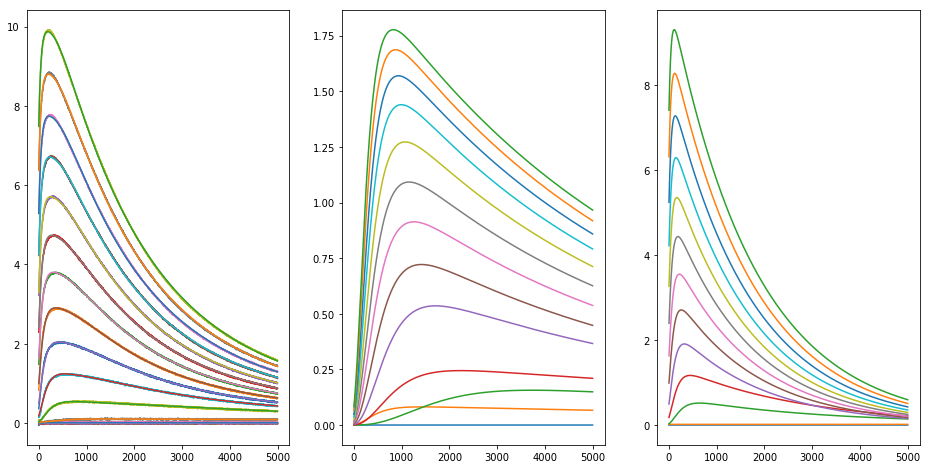

In [58]:
p0 = [
    [1.3140e-08, 2.2719e+04, 1.8343e-20, 5.4145e+00, 8.3185e-07, 1.6742e+04, 2.1029e-14, 3.0771e-01],
    [1.8885e-03, 8.8682e+02, 2.2475e-05, 1.0458e+04, 2.4923e-03, 2.5537e+02, 2.2039e-02, 1.2926e+03],
    [6.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [2.0882e-03, 4.2823e+02, 4.3578e-02, 9.3862e+03, 1.0825e-02, 1.1221e+02, 3.1857e-29, 1.8764e+03],
    [4.9414e-03, 3.6136e+02, 2.1389e-35, 3.9617e+03, 1.0035e-02, 3.0108e+02, 7.8946e-38, 1.0261e+03],
    [5.0414e-03, 3.2136e+02, 2.1389e-35, 3.2617e+03, 1.2035e-02, 2.0108e+02, 7.8946e-38, 1.0261e+03],
    [3.5652e-03, 2.4234e+02, 3.6695e-02, 6.0156e+03, 1.7806e-02, 6.2840e+01, 1.3951e-20, 1.4659e+03],
    [3.8476e-03, 2.1777e+02, 2.2186e-02, 5.8269e+03, 1.8491e-02, 5.5700e+01, 3.4986e-03, 1.4670e+03],
    [4.0330e-03, 1.9504e+02, 5.5298e-18, 5.6382e+03, 2.0223e-02, 5.0004e+01, 8.5453e-03, 1.4661e+03],
    [4.3048e-03, 1.7489e+02, 1.3271e-17, 5.5011e+03, 2.1416e-02, 4.5468e+01, 8.5272e-03, 1.4818e+03],
    [4.4947e-03, 1.5633e+02, 5.7562e-19, 5.4025e+03, 2.2217e-02, 4.1540e+01, 8.2158e-03, 1.4855e+03],
    [4.5359e-03, 1.4154e+02, 5.3694e-19, 5.3021e+03, 2.3634e-02, 3.8512e+01, 7.9238e-03, 1.5139e+03],
    [4.5535e-03, 1.2990e+02, 8.9734e-18, 5.1781e+03, 2.1876e-02, 3.5929e+01, 8.1433e-03, 1.5339e+03]
]
allfits_ext[3], cost = fit_single(ana[3], p0)
print cost
costs3[3] = cost

[2.4051e-04, 7.1644e+01, 3.7967e-21, 4.5507e+03, 3.6100e-03, 8.6068e+00, 1.0945e-22, 7.0852e+01],  1.5510e+00
[1.6497e-03, 3.2344e+02, 9.9297e-03, 1.4889e+04, 6.7153e-04, 1.0003e+01, 1.0000e+00, 2.5768e+02],  1.5580e+00
[6.3191e-03, 8.3459e+02, 6.6150e-06, 9.2594e+03, 1.4889e-02, 1.9878e+02, 7.0637e-02, 2.0683e+03],  1.6164e+00
[6.5183e-03, 4.5934e+02, 4.6970e-02, 9.2821e+03, 2.7426e-02, 1.3804e+02, 2.3413e-02, 2.2086e+03],  1.6322e+00
[1.0071e-02, 3.8835e+02, 9.8783e-02, 6.6073e+03, 4.0088e-02, 1.1017e+02, 1.3566e-36, 1.7716e+03],  1.9393e+00
[1.2708e-02, 3.3791e+02, 8.6599e-02, 5.4739e+03, 4.9300e-02, 9.2045e+01, 7.3201e-35, 1.5975e+03],  2.2768e+00
[1.4291e-02, 3.0883e+02, 8.4752e-02, 5.1633e+03, 5.6797e-02, 8.0261e+01, 1.4135e-05, 1.5213e+03],  2.8326e+00
[1.5692e-02, 2.8034e+02, 8.3760e-02, 4.9587e+03, 6.2505e-02, 7.1045e+01, 1.0118e-05, 1.4801e+03],  3.3432e+00
[1.6761e-02, 2.6149e+02, 7.9514e-02, 4.8472e+03, 6.7630e-02, 6.4160e+01, 1.0808e-26, 1.4543e+03],  3.4855e+00
[1.7420e-0

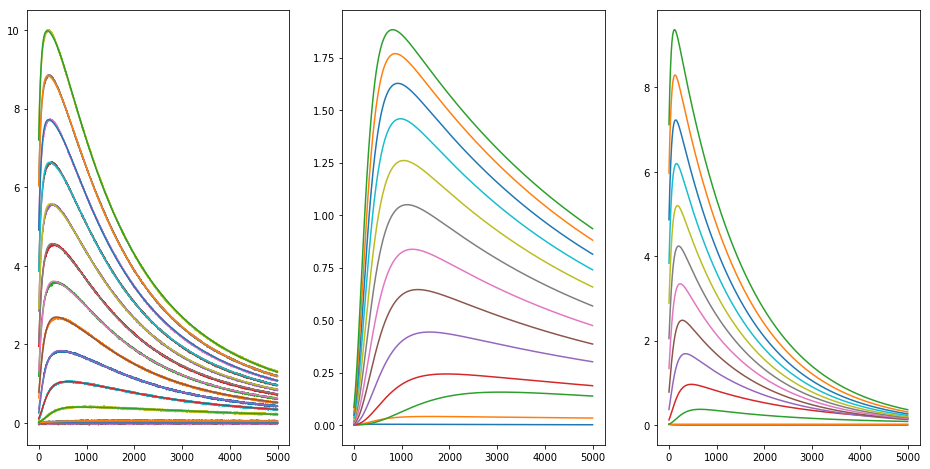

In [59]:
p0 = [
    [1.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [3.6786e-03, 6.8959e+02, 2.8392e-04, 9.6088e+03, 2.4308e-02, 1.5226e+02, 2.1163e-02, 2.3603e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.20438934e-02, 4.17433102e+02, 5.80922725e-02, 5.82964781e+03, 4.08908566e-02, 1.12204344e+02, 1.68942604e-05, 1.59861465e+03],
    [1.42081465e-02, 3.80135749e+02, 6.38591759e-02, 4.87138978e+03, 4.53899075e-02, 9.91871948e+01, 1.04647195e-06, 1.46505568e+03],
    [1.73895186e-02, 2.84885303e+02, 6.61381567e-02, 4.68949830e+03, 5.17874316e-02, 7.48485617e+01, 1.45223442e-08, 1.44136454e+03],
    [1.73895186e-02, 2.74885303e+02, 6.41381567e-02, 4.69949830e+03, 5.57874316e-02, 7.08485617e+01, 1.45223442e-12, 1.44136454e+03],
    [1.73895186e-02, 2.64885303e+02, 6.21381567e-02, 4.70949830e+03, 6.17874316e-02, 6.68485617e+01, 1.45223442e-15, 1.44136454e+03],
    [1.73895186e-02, 2.54885303e+02, 6.01381567e-02, 4.72949830e+03, 6.57874316e-02, 6.28485617e+01, 1.45223442e-18, 1.44136454e+03],
    [1.73895186e-02, 2.44885303e+02, 5.81381567e-02, 4.74949830e+03, 7.17874316e-02, 5.88485617e+01, 1.45223442e-26, 1.44136454e+03],
    [1.75037140e-02, 2.29092127e+02, 5.51733567e-02, 4.78776232e+03, 7.55955872e-02, 5.43700416e+01, 5.21362349e-18, 1.44659691e+03],
    [1.72435134e-02, 2.13699825e+02, 5.23052040e-02, 4.88100112e+03, 7.89005902e-02, 5.06488733e+01, 2.67342944e-15, 1.46119205e+03],
    [1.66858504e-02, 1.97714913e+02, 5.16146762e-02, 4.98309796e+03, 8.17107281e-02, 4.74851633e+01, 9.26682489e-17, 1.48333106e+03]
]
allfits_ext[4], cost = fit_single(ana[4], p0)
print cost
costs3[4] = cost

[3.7825e-03, 3.1182e+02, 6.9481e-01, 2.3364e+04, 9.1033e-03, 1.0399e+01, 9.6829e-08, 2.7289e+02],  1.1375e+00
[1.2724e-02, 2.5437e+02, 3.1953e-02, 2.1923e+04, 5.2428e-03, 7.5184e-01, 1.0000e+00, 1.1457e+03],  1.4363e+00
[2.9919e-03, 7.3360e+02, 4.6559e-08, 6.9615e+04, 4.1675e-02, 1.3409e+02, 1.4616e-01, 1.0847e+04],  1.9551e+00
[1.2869e-02, 1.1023e+03, 7.9835e-05, 3.2748e+04, 6.6414e-02, 1.0852e+02, 6.4110e-02, 5.7659e+03],  8.4890e+00
[1.3529e-02, 3.5885e+02, 2.3130e-33, 3.0622e+04, 7.7208e-02, 8.2703e+01, 3.4870e-02, 5.5174e+03],  1.1973e+01
[1.4593e-02, 3.8861e+02, 3.4283e-14, 2.3974e+04, 9.2262e-02, 7.3368e+01, 3.2433e-02, 4.8014e+03],  1.2462e+01
[1.5056e-02, 3.2897e+02, 3.3194e-04, 2.0797e+04, 1.0246e-01, 6.5197e+01, 3.3551e-02, 4.4806e+03],  1.2401e+01
[1.7071e-02, 2.6536e+02, 3.2594e-19, 1.5210e+04, 1.0970e-01, 5.7660e+01, 4.2992e-02, 4.1886e+03],  1.3431e+01
[1.9771e-02, 2.2293e+02, 4.9917e-17, 1.3222e+04, 1.1420e-01, 5.1356e+01, 4.4391e-02, 3.9787e+03],  1.6692e+01
[2.2303e-0

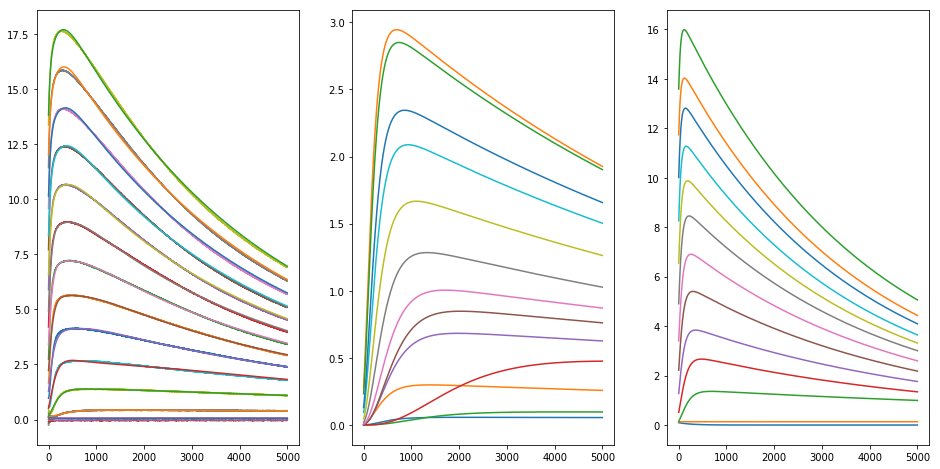

In [60]:
p0 = [
    [2.4385e-03, 8.6892e+02, 1.4340e-04, 3.7488e+04, 3.8277e-02, 1.4616e+02, 7.7392e-02, 1.0809e+04],
    [2.4385e-03, 8.6892e+02, 1.4340e-04, 3.7488e+04, 3.8277e-02, 1.4616e+02, 7.7392e-02, 1.0809e+04],
    [7.1551e-03, 5.3459e+02, 5.1215e-23, 3.7265e+04, 5.9033e-02, 1.0678e+02, 3.2432e-02, 7.1503e+03],
    [1.3096e-02, 5.2826e+02, 8.3278e-04, 2.4369e+04, 7.6914e-02, 8.7307e+01, 8.8415e-03, 5.3261e+03],
    [1.7077e-02, 2.6218e+02, 7.7466e-04, 1.5035e+04, 1.0674e-01, 5.8387e+01, 1.6584e-02, 4.1912e+03],
    [1.7077e-02, 2.6218e+02, 7.7466e-04, 1.5035e+04, 1.0674e-01, 5.8387e+01, 1.6584e-02, 4.1912e+03],
    [1.7077e-02, 2.6218e+02, 7.7466e-04, 1.5035e+04, 1.0674e-01, 5.8387e+01, 1.6584e-02, 4.1912e+03],
    [3.8476e-03, 2.1777e+02, 2.2186e-02, 5.8269e+03, 1.8491e-02, 5.5700e+01, 3.4986e-03, 1.4670e+03],
    [4.0330e-03, 1.9504e+02, 5.5298e-18, 5.6382e+03, 2.0223e-02, 5.0004e+01, 8.5453e-03, 1.4661e+03],
    [4.3048e-03, 1.7489e+02, 1.3271e-17, 5.5011e+03, 2.1416e-02, 4.5468e+01, 8.5272e-03, 1.4818e+03],
    [4.4947e-03, 1.5633e+02, 5.7562e-19, 5.4025e+03, 2.2217e-02, 4.1540e+01, 8.2158e-03, 1.4855e+03],
    [4.5359e-03, 1.4154e+02, 5.3694e-19, 5.3021e+03, 2.3634e-02, 3.8512e+01, 7.9238e-03, 1.5139e+03],
    [4.5535e-03, 1.2990e+02, 8.9734e-18, 5.1781e+03, 2.1876e-02, 3.5929e+01, 8.1433e-03, 1.5339e+03]
]
allfits_ext[5], cost = fit_single(ana[5], p0)
print cost
costs3[5] = cost

In [61]:
# costs1_mse = np.sqrt(np.array(costs1)/len(t))
print costs3
costs3_mse = np.sqrt(np.array(costs3)/len(t))
print np.mean(costs1_mse[:6]), np.std(costs1_mse[:6])
print np.mean(costs3_mse[:6]), np.std(costs3_mse[:6])
tt_mse, p_mse = scipy.stats.ttest_rel(costs1_mse[:6], costs3_mse[:6])
print tt_mse, p_mse

[19.81878636697993, 21.598070189409338, 19.73534530113442, 27.77081576425483, 33.598347449991174, 188.38322313403955]
0.1311265377248375 0.04623785723716619
0.03204457731870194 0.016635150841688522
5.617294830214149 0.002474334765966153


In [70]:
# only old recs from here on out, for the writeup
ana = ana[:6]

Let's have a look at the voltage dependency of these params:

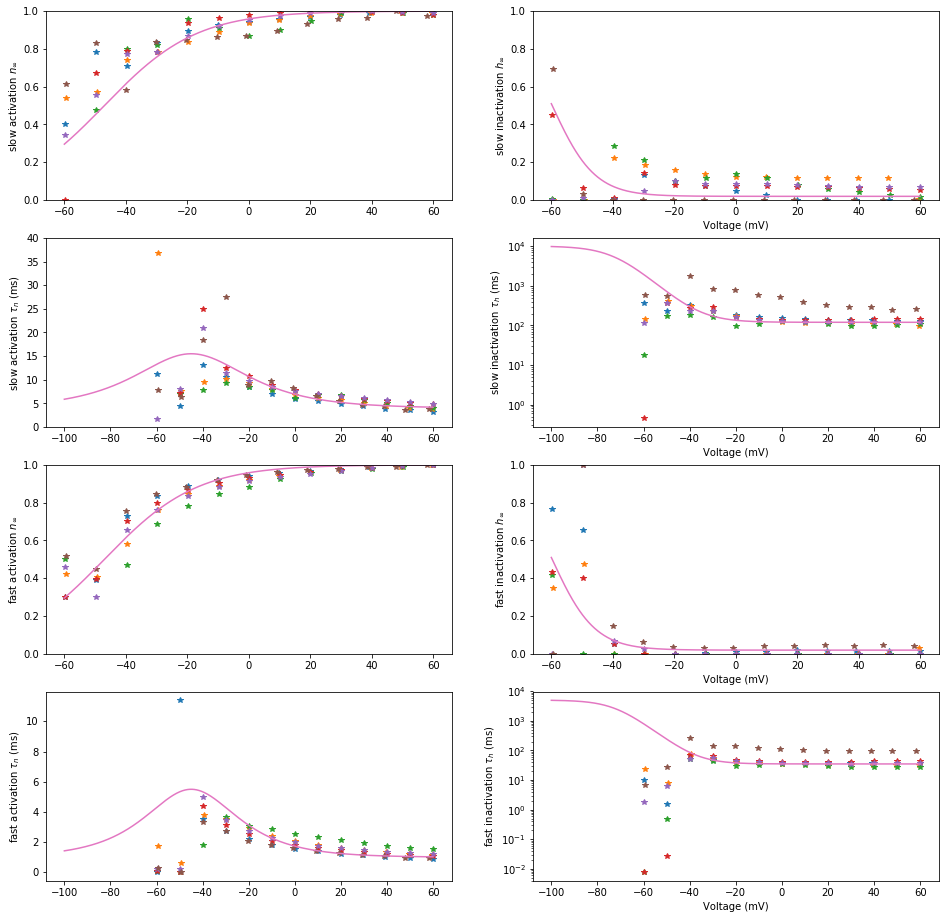

In [79]:
plt.figure(figsize=(16,16))

plt.subplot(4,2,1).set_ylabel(r'slow activation $n_\infty$')
plt.subplot(4,2,2).set_ylabel(r'slow inactivation $h_\infty$')
plt.subplot(4,2,3).set_ylabel(r'slow activation $\tau_n$ (ms)')
plt.subplot(4,2,4).set_ylabel(r'slow inactivation $\tau_h$ (ms)')

plt.subplot(4,2,5).set_ylabel(r'fast activation $n_\infty$')
plt.subplot(4,2,6).set_ylabel(r'fast inactivation $h_\infty$')
plt.subplot(4,2,7).set_ylabel(r'fast activation $\tau_n$ (ms)')
plt.subplot(4,2,8).set_ylabel(r'fast inactivation $\tau_h$ (ms)')

V = []
ns, hs, tns, ths = [],[],[],[]
nf, hf, tnf, thf = [],[],[],[]

for i, a in enumerate(ana):    
    ret, V_ = zip(*allfits_ext[i])
    params = [r.x for r in ret]
    V_ += a.params['E_K']
    V.extend(V_)
    
    # slow activation
    plt.subplot(4, 2, 1)
    p = [el[0] for el in params]
    a.params['gA_slow'] = max(p[-7:])
    n_ = [(el / a.params['gA_slow'])**0.25 for el in p]
    ns.extend(n_)
    plt.plot(V_, n_, '*')
    plt.ylim(0,1)
    
    # slow inactivation
    plt.subplot(4,2,2)
    h_ = [el[2] for el in params]
    hs.extend(h_)
    plt.plot(V_, h_, '*')
    
    # slow activation tau
    plt.subplot(4,2,3)
#     tn_ = [(el[1] if el[1] < 2500 else 2600) * Kv21.tres for el in params]
    tn_ = [el[1] * Kv14.tres for el in params]
    tns.extend(tn_)
    plt.plot(V_, tn_, '*')
    
    # slow inactivation tau
    plt.subplot(4,2,4)
    th_ = [el[3] * Kv14.tres for el in params]
    ths.extend(th_)
    plt.semilogy(V_, th_, '*')
    
    # fast activation
    plt.subplot(4, 2, 5)
    p = [el[4] for el in params]
    a.params['gA_fast'] = max(p[-7:])
    n_ = [(el / a.params['gA_fast'])**0.25 for el in p]
    nf.extend(n_)
    plt.plot(V_, n_, '*')
    plt.ylim(0,1)
    
    # fast inactivation
    plt.subplot(4,2,6)
    h_ = [el[6] for el in params]
    hf.extend(h_)
    plt.plot(V_, h_, '*')
    
    # fast activation tau
    plt.subplot(4,2,7)
#     tn_ = [(el[1] if el[1] < 2500 else 2600) * Kv21.tres for el in params]
    tn_ = [el[5] * Kv14.tres for el in params]
    tnf.extend(tn_)
    plt.plot(V_, tn_, '*')
    
    # fast inactivation tau
    plt.subplot(4,2,8)
    th_ = [el[7] * Kv14.tres for el in params]
    thf.extend(th_)
    plt.semilogy(V_, th_, '*')
    
    
    
def sigmoid(p, v):
    return 1/(1+np.exp((p[0]-v)/p[1]))
Vprobe = np.arange(-60,60,0.1)
ns_p0 = [-47, 15]
plt.subplot(4,2,1)
plt.plot(Vprobe, sigmoid(ns_p0, Vprobe))

def sigmoid_min(p, v):
    return p[2] + (1-p[2])/(1+np.exp((p[0]-v)/p[1]))
hs_p0 = [-60.,-7.,.02]
plt.subplot(4,2,2)
plt.plot(Vprobe, sigmoid_min(hs_p0, Vprobe))
plt.ylim((0,1))
plt.xlabel('Voltage (mV)')

tauns_p0 = [4, 23., 45., 22., -22.]
def tau_model(p, V):
#   tau_min + tau_max/(np.exp((tau_off+V)/tau_slope1) + np.exp((tau_off+V)/tau_slope2))
    return p[0] + p[1]/(np.exp((p[2]+V)/p[3]) + np.exp((p[2]+V)/p[4]))
plt.subplot(4,2,3)
Vprobe = np.arange(-100,60,0.1)
plt.plot(Vprobe, tau_model(tauns_p0, Vprobe))
plt.ylim(0,40)

tauhs_p0 = [120., 1e4, 72., 8.]
def taui_model(p, V):
#     $(tauhK_min) + $(tauhK_max)/(1.0 + exp(($(tauhK_mid)-$(V))/$(tauhK_slope)))
    return p[0] + p[1]/(1. + np.exp((p[2]+V)/p[3]))
plt.subplot(4,2,4)
plt.semilogy(Vprobe, taui_model(tauhs_p0, Vprobe))
plt.xlabel('Voltage (mV)')

Vprobe = np.arange(-60,60,0.1)
#plt.ylim(0,1.1)
plt.subplot(4,2,5)
nf_p0 = [-47, 15]
plt.plot(Vprobe, sigmoid(nf_p0, Vprobe))

plt.subplot(4,2,6)
hf_p0 = [-60.,-7.,.02]
plt.plot(Vprobe, sigmoid_min(hf_p0, Vprobe))
plt.ylim((0,1))
plt.xlabel('Voltage (mV)')

taunf_p0 = [1, 9., 45., 18., -18.]
Vprobe = np.arange(-100,60,0.1)
plt.subplot(4,2,7)
plt.plot(Vprobe, tau_model(taunf_p0, Vprobe))
#plt.ylim(0,15)

tauhf_p0 = [35., 5e3, 72., 7.]
plt.subplot(4,2,8)
plt.semilogy(Vprobe, taui_model(tauhf_p0, Vprobe))
plt.xlabel('Voltage (mV)')
#plt.ylim(1e1, 2e4)

plt.savefig('/home/kernfel/Documents/Thesis/Models figures/Kv14-fit-allvars.svg')

In [22]:
for a in ana:
    print '%s:\n%s\n' % (a.paramsfile, a.params_str())
    a.write()

/home/kernfel/Documents/Data/Oocytes/2017_12_06_0039.params:
gl:	2.526743 μS
El:	-28.738655 mV
gA:	83.230559 μS
EK:	-80.001965 mV
C:	176.326881 nF
gA_fast:	81.876076 μS
gA_slow:	18.535426 μS


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0059.params:
gl:	9.924003 μS
El:	-14.031340 mV
gA:	75.895646 μS
EK:	-75.920659 mV
C:	183.766556 nF
gA_fast:	79.338654 μS
gA_slow:	18.093808 μS


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0064.params:
gl:	1.749784 μS
El:	-31.197546 mV
gA:	19.988201 μS
EK:	-83.274804 mV
C:	211.055611 nF
gA_fast:	17.040910 μS
gA_slow:	11.781791 μS


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0074.params:
gl:	1.205766 μS
El:	-18.762992 mV
gA:	76.309452 μS
EK:	-76.495133 mV
C:	188.968863 nF
gA_fast:	79.193030 μS
gA_slow:	16.895008 μS


/home/kernfel/Documents/Data/Oocytes/2017_12_06_0079.params:
gl:	2.149622 μS
El:	-14.324841 mV
gA:	75.935608 μS
EK:	-77.991601 mV
C:	202.428834 nF
gA_fast:	81.710736 μS
gA_slow:	17.503690 μS


/home/kernfel/Documents/Data/Oocyte

The number of viable recordings being very small, hand-tuned parameters will likely yield better results. Note, $n_\infty$ and $h_\infty$ seem to behave very similarly between the two components, and are therefore modelled with largely the same parameters.

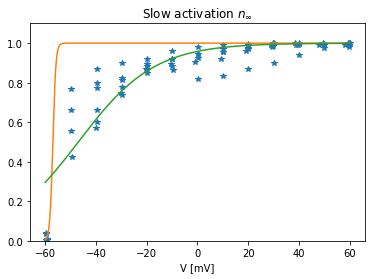

In [23]:
def sigmoid(p, v):
    return 1/(1+np.exp((p[0]-v)/p[1]))
Vprobe = np.arange(-60,60,0.1)
fit_ns = scipy.optimize.least_squares(lambda p, x, y: sigmoid(p,x) - y, [10, 10], args = (V, ns))
plt.plot(V, ns, '*')
plt.plot(Vprobe, sigmoid(fit_ns.x, Vprobe))
plt.title(r'Slow activation $n_\infty$')
plt.xlabel('V [mV]')
plt.ylim(0,1.1)

ns_p0 = [-47, 15]
plt.plot(Vprobe, sigmoid(ns_p0, Vprobe));

V_half =  -219.49374421525758
V_slope =  -1.377220509678465
noninact =  0.020951717390792057


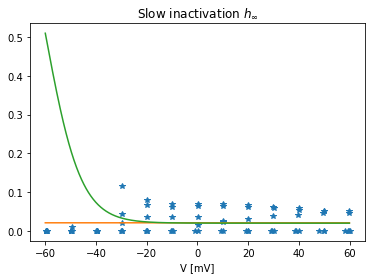

In [24]:
def sigmoid_min(p, v):
    return p[2] + (1-p[2])/(1+np.exp((p[0]-v)/p[1]))
fit_hs = scipy.optimize.least_squares(lambda p, x, y: sigmoid_min(p,x) - y, [-48., -5., .02], args = (V, hs))
plt.plot(V, hs, '*')
plt.plot(Vprobe, sigmoid_min(fit_hs.x, Vprobe))
plt.title(r'Slow inactivation $h_\infty$')
plt.xlabel('V [mV]')
print 'V_half = ', fit_hs.x[0]
print 'V_slope = ', fit_hs.x[1]
print 'noninact = ', fit_hs.x[2]

hs_p0 = [-60.,-7.,.02]
plt.plot(Vprobe, sigmoid_min(hs_p0, Vprobe));

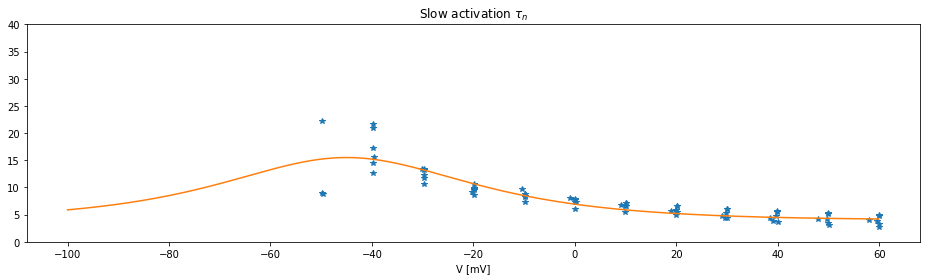

In [25]:
tauns_p0 = [4, 23., 45., 22., -22.]
def tau_model(p, V):
#   tau_min + tau_max/(np.exp((tau_off+V)/tau_slope1) + np.exp((tau_off+V)/tau_slope2))
    return p[0] + p[1]/(np.exp((p[2]+V)/p[3]) + np.exp((p[2]+V)/p[4]))

Vprobe = np.arange(-100,60,0.1)

plt.figure(figsize=(16,4))
plt.plot(V, tns, '*')
plt.plot(Vprobe, tau_model(tauns_p0, Vprobe))

plt.title(r'Slow activation $\tau_n$')
plt.ylim(0,40)
plt.xlabel('V [mV]');

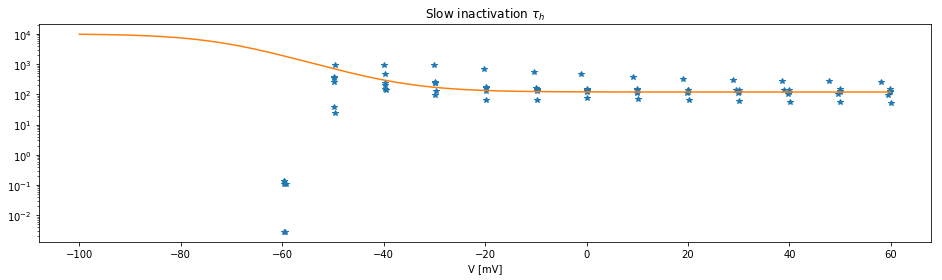

In [26]:
tauhs_p0 = [120., 1e4, 72., 8.]
def taui_model(p, V):
#     $(tauhK_min) + $(tauhK_max)/(1.0 + exp(($(tauhK_mid)-$(V))/$(tauhK_slope)))
    return p[0] + p[1]/(1. + np.exp((p[2]+V)/p[3]))

plt.figure(figsize=(16,4))
plt.semilogy(V, ths, '*')
plt.semilogy(Vprobe, taui_model(tauhs_p0, Vprobe))

plt.title(r'Slow inactivation $\tau_h$')
# plt.ylim(3e1, 2e4)
plt.xlabel('V [mV]');

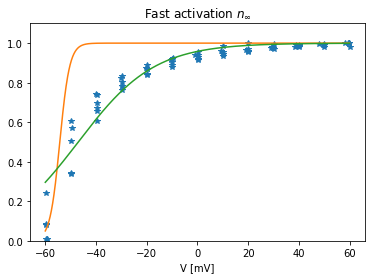

In [27]:
def sigmoid(p, v):
    return 1/(1+np.exp((p[0]-v)/p[1]))
Vprobe = np.arange(-60,60,0.1)
fit_nf = scipy.optimize.least_squares(lambda p, x, y: sigmoid(p,x) - y, [10, 10], args = (V, nf))
plt.plot(V, nf, '*')
plt.plot(Vprobe, sigmoid(fit_nf.x, Vprobe))
plt.title(r'Fast activation $n_\infty$')
plt.xlabel('V [mV]')
plt.ylim(0,1.1)

nf_p0 = [-47, 15]
plt.plot(Vprobe, sigmoid(nf_p0, Vprobe));

V_half =  -104.67620224255207
V_slope =  -19.256426225317284
noninact =  0.0005965467458049536


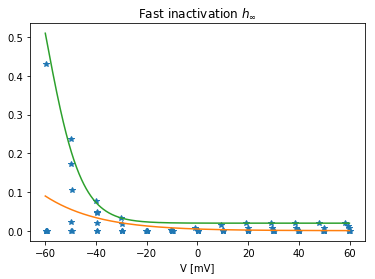

In [28]:
def sigmoid_min(p, v):
    return p[2] + (1-p[2])/(1+np.exp((p[0]-v)/p[1]))
fit_hf = scipy.optimize.least_squares(lambda p, x, y: sigmoid_min(p,x) - y, [-48., -5., .02], args = (V, hf))
plt.plot(V, hf, '*')
plt.plot(Vprobe, sigmoid_min(fit_hf.x, Vprobe))
plt.title(r'Fast inactivation $h_\infty$')
plt.xlabel('V [mV]')
print 'V_half = ', fit_hf.x[0]
print 'V_slope = ', fit_hf.x[1]
print 'noninact = ', fit_hf.x[2]

hf_p0 = [-60.,-7.,.02]
plt.plot(Vprobe, sigmoid_min(hf_p0, Vprobe));

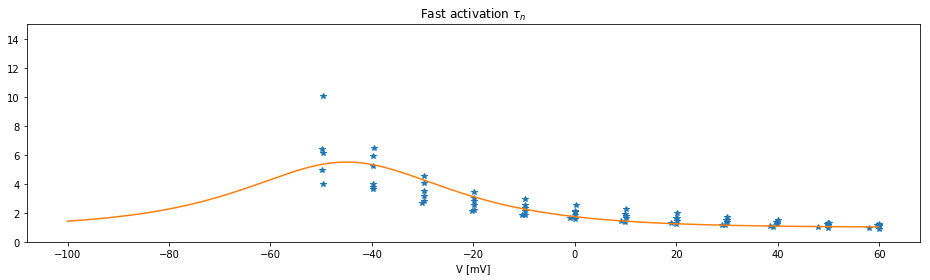

In [29]:
taunf_p0 = [1, 9., 45., 18., -18.]
def tau_model(p, V):
#   tau_min + tau_max/(np.exp((tau_off+V)/tau_slope1) + np.exp((tau_off+V)/tau_slope2))
    return p[0] + p[1]/(np.exp((p[2]+V)/p[3]) + np.exp((p[2]+V)/p[4]))

Vprobe = np.arange(-100,60,0.1)

plt.figure(figsize=(16,4))
plt.plot(V, tnf, '*')
plt.plot(Vprobe, tau_model(taunf_p0, Vprobe))

plt.title(r'Fast activation $\tau_n$')
plt.ylim(0,15)
plt.xlabel('V [mV]');

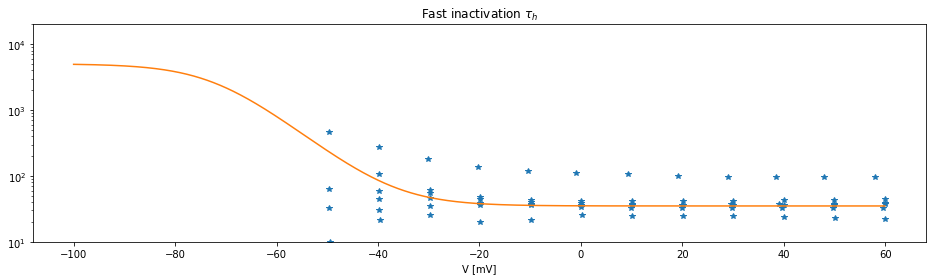

In [30]:
tauhf_p0 = [35., 5e3, 72., 7.]
def taui_model(p, V):
#     $(tauhK_min) + $(tauhK_max)/(1.0 + exp(($(tauhK_mid)-$(V))/$(tauhK_slope)))
    return p[0] + p[1]/(1. + np.exp((p[2]+V)/p[3]))

plt.figure(figsize=(16,4))
plt.semilogy(V, thf, '*')
plt.semilogy(Vprobe, taui_model(tauhf_p0, Vprobe))

plt.title(r'Fast inactivation $\tau_h$')
plt.ylim(1e1, 2e4)
plt.xlabel('V [mV]');

I don't have any data of my own for recovery from inactivation, but the few data points gleaned from the Japanese papers help, for what they're worth.
Now for the money shot: How do these values match the tail currents?

In [80]:
def state_at(t, V, state):
    '''Calculates the state (n,h) after @a t ms of holding at @a V mV from an initial @a state'''
    
    nsinf = sigmoid(ns_p0, V)
    tauns = tau_model(tauns_p0, V)
    ns = nsinf - (nsinf-state[0]) * np.exp(-t/tauns)

    hsinf = sigmoid_min(hs_p0, V)
    tauhs = taui_model(tauhs_p0, V)
    hs = hsinf - (hsinf-state[1]) * np.exp(-t/tauhs)
    
    nfinf = sigmoid(nf_p0, V)
    taunf = tau_model(taunf_p0, V)
    nf = nsinf - (nfinf-state[2]) * np.exp(-t/taunf)

    hfinf = sigmoid_min(hf_p0, V)
    tauhf = taui_model(tauhf_p0, V)
    hf = hfinf - (hfinf-state[3]) * np.exp(-t/tauhf)
    
    return (ns, hs, nf, hf)

def HH_state0(t, V, params, state0):
    state = state_at(t, V, state0)
    return (V - params['E_K']) * (params['gA_slow'] * state[0]**4 * state[1]
                                  + params['gA_fast'] * state[2]**4 * state[3])

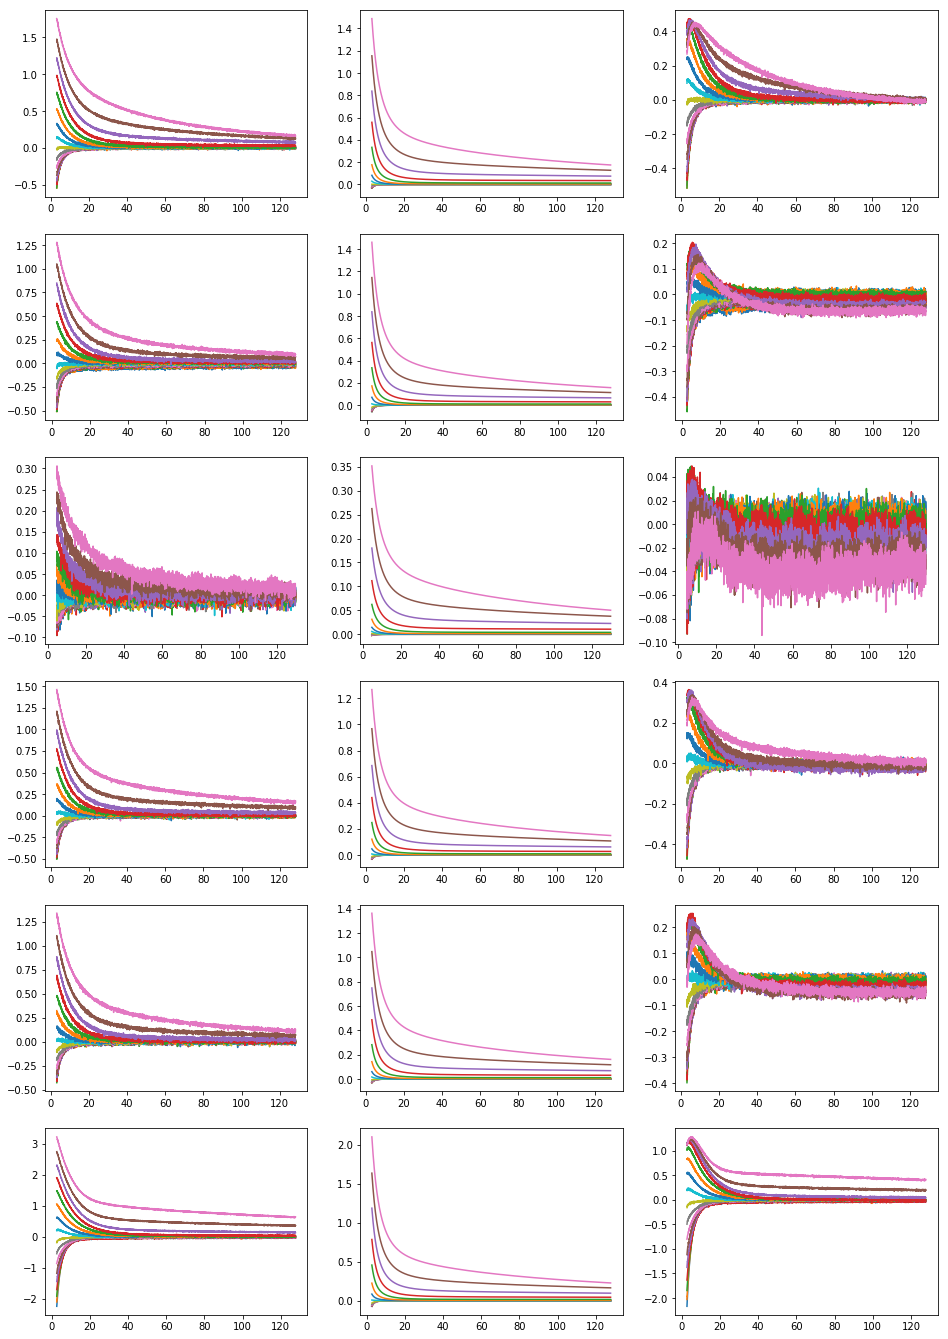

In [81]:
plt.figure(figsize=(16,4*len(ana)))
dur = 5000

tailV = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]

for j,a in enumerate(ana):
    t0 = a.rec2.tail_cut
    t = np.arange(t0 - Kv14.rec2_limits[0], t0+dur - Kv14.rec2_limits[0]) * Kv14.tres
    
    for i, current, voltage, tail_baseline in zip(range(len(a.rec2.current)),
                                                  a.rec2.current,
                                                  a.rec2.voltage,
                                                  a.rec2.tail_baseline):
        state_after_prepulse = state_at(Kv14.tres*(Kv14.rec2_limits[0]-Kv14.rec2_prepulse),
                                        np.median(voltage[Kv14.rec2_prepulse:Kv14.rec2_limits[0]]),
                                        (0,1,0,1))
        
        medV = np.median(voltage[t0:t0+dur])
        model_current = HH_state0(t, medV, a.params, state_after_prepulse)
        exp_current = current[t0:t0+dur] - tail_baseline
        
        tailV[j][i] = medV

        plt.subplot(len(ana),3,3*j+1)
        plt.plot(t, exp_current)
        
        plt.subplot(len(ana),3,3*j+2)
        plt.plot(t, model_current)
        
        plt.subplot(len(ana),3,3*j+3)
        plt.plot(t, exp_current-model_current)

Whoops, that's a bunch of taus out of whack. Let's fit them some...

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in power


0.8701571558424975


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in power
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


3.615310976476551
0.977023857059272
0.8700011651482176
2.4972682076568113
5.645942625919915

2.412617331350544


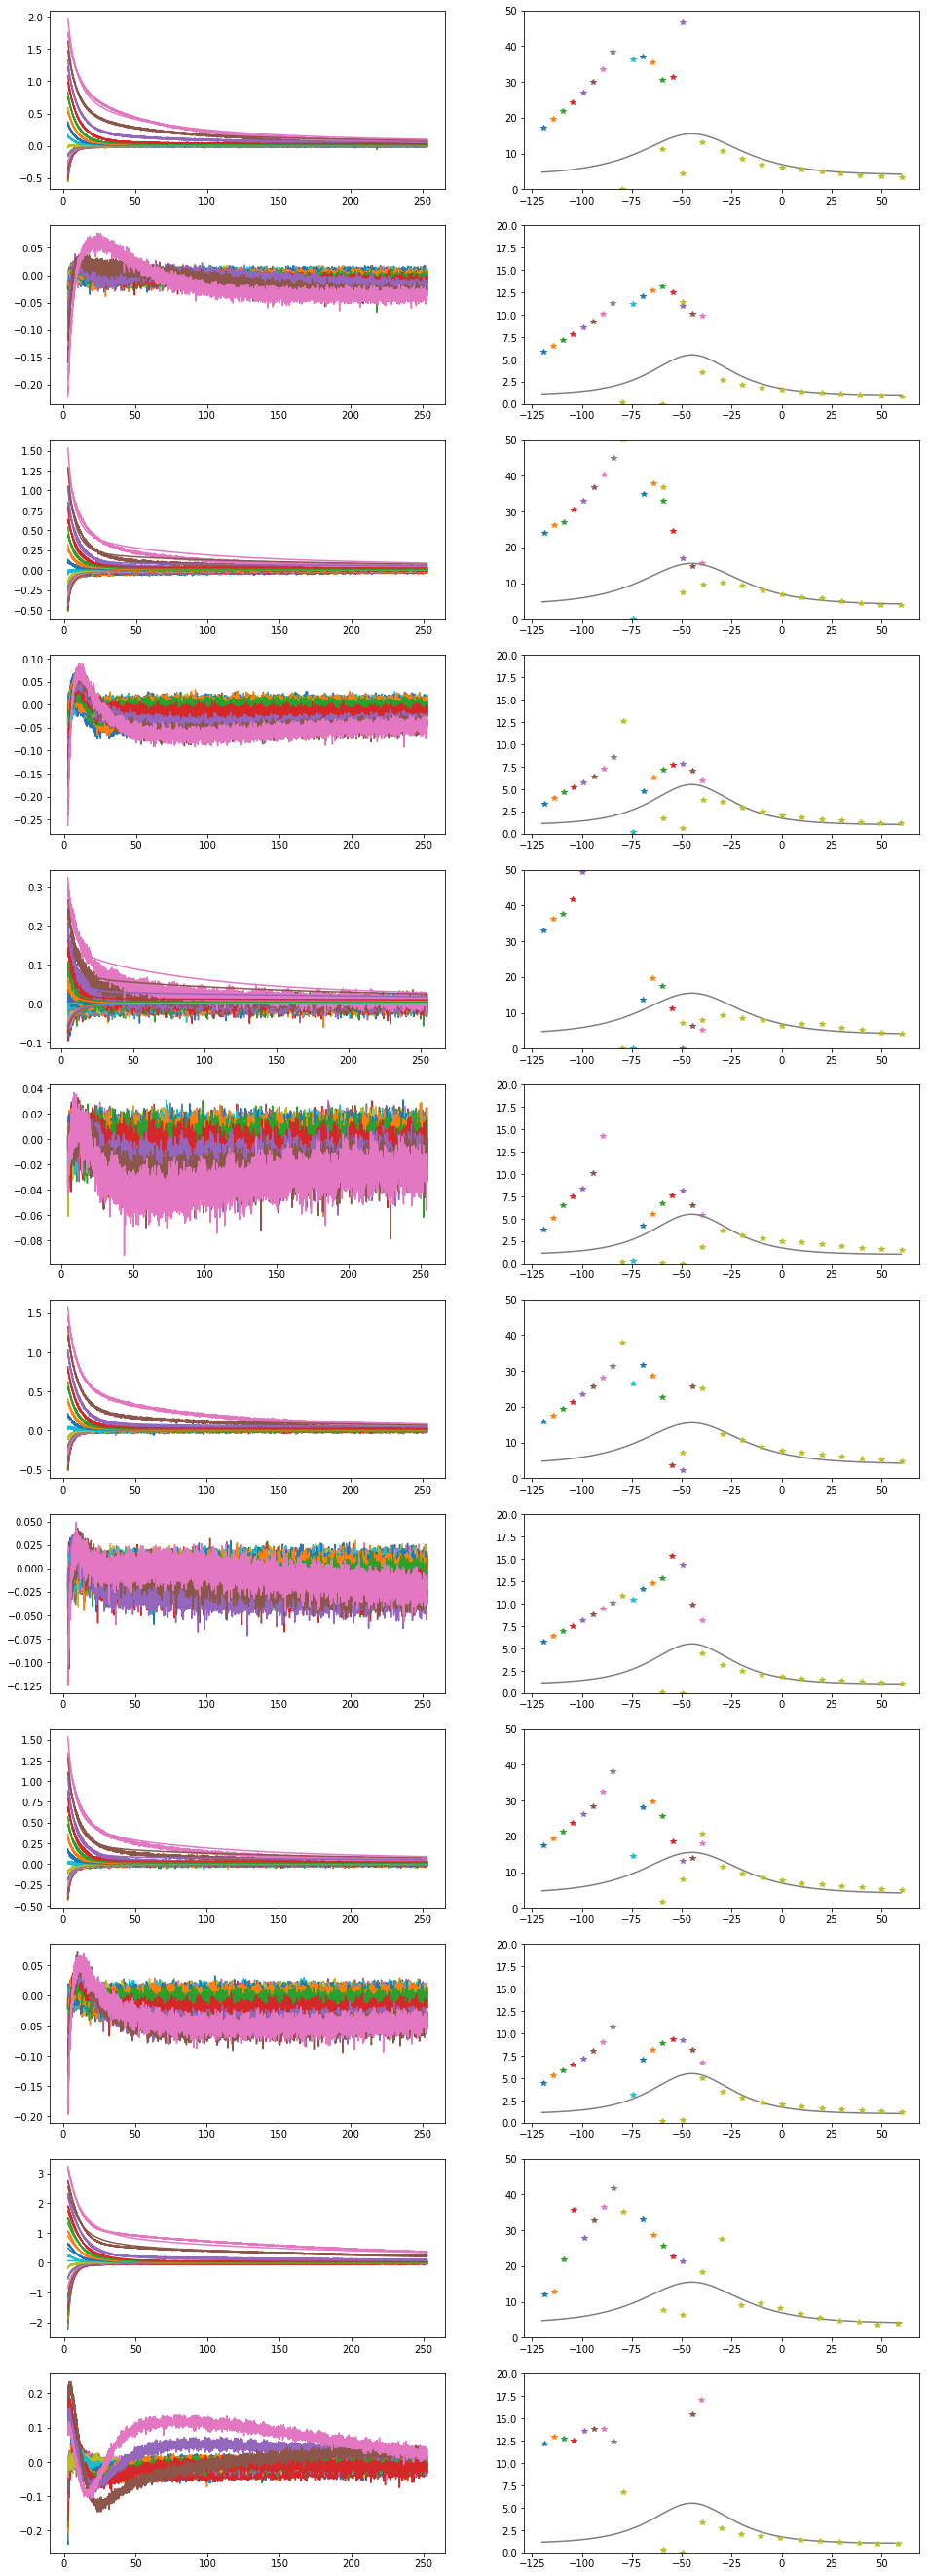

In [82]:
plt.figure(figsize=(16,8*len(ana)))
dur = 10000

def tau_guess(V):
    tauns = tau_model(tauns_p0, V)
    taunf = tau_model(taunf_p0, V)
    return [tauns, taunf]
    
def state_fixedtau(t, V, state, tau):
    nsinf = sigmoid(ns_p0, V)
    ns = nsinf - (nsinf-state[0]) * np.exp(-t/tau[0])

    hsinf = sigmoid_min(hs_p0, V)
    tauhs = taui_model(tauhs_p0, V)
    hs = hsinf - (hsinf-state[1]) * np.exp(-t/tauhs)
    
    nfinf = sigmoid(nf_p0, V)
    nf = nfinf - (nfinf-state[2]) * np.exp(-t/tau[1])

    hfinf = sigmoid_min(hf_p0, V)
    tauhf = taui_model(tauhf_p0, V)
    hf = hfinf - (hfinf-state[3]) * np.exp(-t/tauhf)
    
    return (ns, hs, nf, hf)

def HH_state0_tau(t, V, params, state0, tau):
    state = state_fixedtau(t, V, state0, tau)
    return (V - params['E_K']) * (params['gA_slow'] * state[0]**4 * state[1]
                                  + params['gA_fast'] * state[2]**4 * state[3])

taufits_ts = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]
taufits_tf = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]

mean_cost = 0.
for j,a in enumerate(ana):
    t0 = a.rec2.tail_cut
    t = np.arange(t0 - Kv14.rec2_limits[0], t0+dur - Kv14.rec2_limits[0]) * Kv14.tres
    sum_cost = 0.
    
    for current, tail_baseline in zip(a.rec2.current, a.rec2.tail_baseline):
        plt.subplot(2*len(ana),2,4*j+1)
        plt.plot(t, current[t0:t0+dur] - tail_baseline)
    plt.gca().set_prop_cycle(None)
    
    for i, current, voltage, tail_baseline in zip(range(len(a.rec2.current)),
                                                  a.rec2.current,
                                                  a.rec2.voltage,
                                                  a.rec2.tail_baseline):
        state_after_prepulse = state_at(Kv14.tres*(Kv14.rec2_limits[0]-Kv14.rec2_prepulse),
                                        np.median(voltage[Kv14.rec2_prepulse:Kv14.rec2_limits[0]]),
                                        (0,1,0,1))
        
        medV = tailV[j][i]
        exp_current = current[t0:t0+dur] - tail_baseline
        
        fit = scipy.optimize.least_squares(lambda p:
                   exp_current - HH_state0_tau(t, medV, a.params, state_after_prepulse, p),
                                           tau_guess(medV))
        sum_cost += fit.cost
        
        plt.subplot(2*len(ana),2,4*j+1)
        plt.plot(t, HH_state0_tau(t, medV, a.params, state_after_prepulse, fit.x))
        
        plt.subplot(2*len(ana),2,4*j+3)
        plt.plot(t, exp_current - HH_state0_tau(t, medV, a.params, state_after_prepulse, fit.x))
    
        plt.subplot(2*len(ana),2,4*j+2)
        plt.plot(medV, fit.x[0], '*')
    
        plt.subplot(2*len(ana),2,4*j+4)
        plt.plot(medV, fit.x[1], '*')
        
        taufits_ts[j][i] = fit.x[0]
        taufits_tf[j][i] = fit.x[1]
    
    Vprobe = np.arange(-120, 60, 0.1)
    tauprobe = tau_guess(Vprobe)
    
    ret, V_ = zip(*allfits_ext[j])
    params = [r.x for r in ret]
    V_ += a.params['E_K']
    tns_ = [el[1] * Kv14.tres for el in params]
    tnf_ = [el[5] * Kv14.tres for el in params]
    
    plt.subplot(2*len(ana),2,4*j+2)
    plt.plot(Vprobe, tauprobe[0])
    plt.plot(V_, tns_, '*')
    plt.ylim(0,50)
    
    plt.subplot(2*len(ana),2,4*j+4)
    plt.plot(Vprobe, tauprobe[1])
    plt.plot(V_, tnf_, '*')
    plt.ylim(0,20)
    
    cost = sum_cost/len(a.rec2.current)
    mean_cost += cost
    print cost
print
print mean_cost/len(ana)

Looks like tau isn't a symmetrical bump here. Let's fix this!

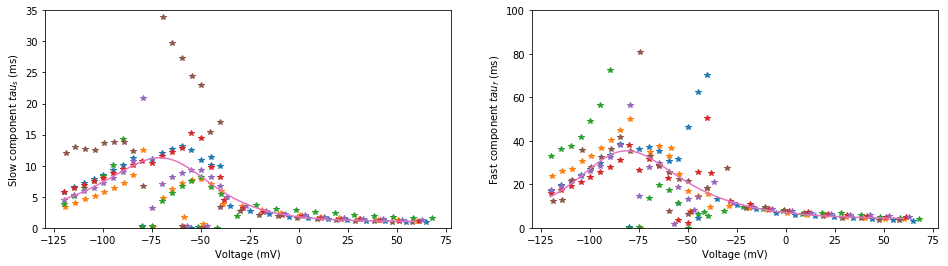

In [92]:
plt.figure(figsize=(16,4))

for taus, tauf, V, fext in zip(taufits_ts, taufits_tf, tailV, allfits_ext):
    ret, V_ = zip(*fext)
    params = [r.x for r in ret]
    V_ += a.params['E_K']
    tns_ = [el[1] * Kv14.tres for el in params]
    tnf_ = [el[5] * Kv14.tres for el in params]
    
    V = np.concatenate((V,V_))
    
    plt.subplot(1,2,2)
    plt.plot(V, np.concatenate((taus, tns_)), '*')
    
    plt.subplot(1,2,1)
    plt.plot(V, np.concatenate((tauf, tnf_)), '*')

Vprobe = np.arange(-120,60,0.1)
tauprobe = tau_guess(Vprobe)

tauns_p1 = [4, 62., 85., 28., -20.]
taunf_p1 = [1, 20., 65., 20., -32.]

plt.subplot(1,2,2)
# plt.plot(Vprobe, tauprobe[0])
plt.plot(Vprobe, tau_model(tauns_p1, Vprobe))
plt.ylim(0, 100)
plt.ylabel('Fast component $tau_f$ (ms)')
plt.xlabel('Voltage (mV)')

plt.subplot(1,2,1)
# plt.plot(Vprobe, tauprobe[1])
plt.plot(Vprobe, tau_model(taunf_p1, Vprobe))
plt.ylim(0, 35);
plt.ylabel('Slow component $tau_s$ (ms)')
plt.xlabel('Voltage (mV)')

plt.savefig('/home/kernfel/Documents/Thesis/Models figures/Kv14-taun.svg')

That looks better, let's see the residual now!

In [93]:
def state_at_1(t, V, state):
    '''Calculates the state (n,h) after @a t ms of holding at @a V mV from an initial @a state'''
    
    nsinf = sigmoid(ns_p0, V)
    tauns = tau_model(tauns_p1, V)
    ns = nsinf - (nsinf-state[0]) * np.exp(-t/tauns)

    hsinf = sigmoid_min(hs_p0, V)
    tauhs = taui_model(tauhs_p0, V)
    hs = hsinf - (hsinf-state[1]) * np.exp(-t/tauhs)
    
    nfinf = sigmoid(nf_p0, V)
    taunf = tau_model(taunf_p1, V)
    nf = nfinf - (nfinf-state[2]) * np.exp(-t/taunf)

    hfinf = sigmoid_min(hf_p0, V)
    tauhf = taui_model(tauhf_p0, V)
    hf = hfinf - (hfinf-state[3]) * np.exp(-t/tauhf)
    
    return (ns, hs, nf, hf)

def HH_state0_1(t, V, params, state0):
    state = state_at_1(t, V, state0)
    return (V - params['E_K']) * (params['gA_slow'] * state[0]**4 * state[1]
                                  + params['gA_fast'] * state[2]**4 * state[3])

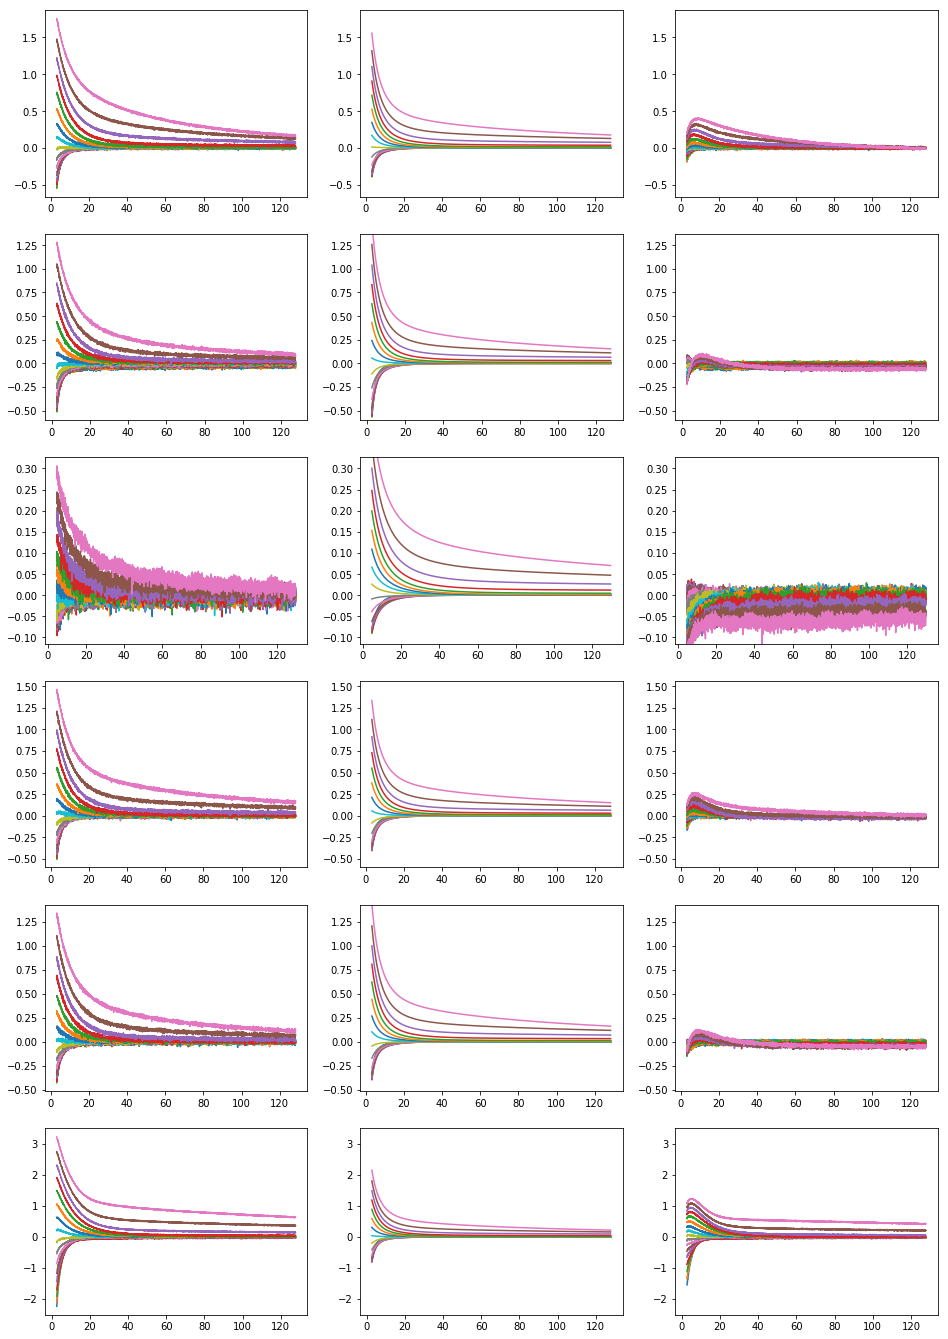

In [36]:
plt.figure(figsize=(16,4*len(ana)))
dur = 5000

tailV = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]

for j,a in enumerate(ana):
    t0 = a.rec2.tail_cut
    t = np.arange(t0 - Kv14.rec2_limits[0], t0+dur - Kv14.rec2_limits[0]) * Kv14.tres
    
    for i, current, voltage, tail_baseline in zip(range(len(a.rec2.current)),
                                                  a.rec2.current,
                                                  a.rec2.voltage,
                                                  a.rec2.tail_baseline):
        state_after_prepulse = state_at_1(Kv14.tres*(Kv14.rec2_limits[0]-Kv14.rec2_prepulse),
                                        np.median(voltage[Kv14.rec2_prepulse:Kv14.rec2_limits[0]]),
                                        (0,1,0,1))
        
        medV = np.median(voltage[t0:t0+dur])
        model_current = HH_state0_1(t, medV, a.params, state_after_prepulse)
        exp_current = current[t0:t0+dur] - tail_baseline
        
        tailV[j][i] = medV

        plt.subplot(len(ana),3,3*j+1)
        plt.plot(t, exp_current)
        
        plt.subplot(len(ana),3,3*j+2)
        plt.plot(t, model_current)
        
        plt.subplot(len(ana),3,3*j+3)
        plt.plot(t, exp_current-model_current)

    plt.subplot(len(ana),3,3*j+1)
    limExp = plt.ylim()
    plt.subplot(len(ana),3,3*j+2)
    plt.ylim(limExp)
    plt.subplot(len(ana),3,3*j+3)
    plt.ylim(limExp)

Not perfect, but pretty much good enough, as far as I'm concerned.

3.3102349569316565
1.8067188435677806
0.46220802959687296
1.6902729782530694
1.4645333795237097
22.12001663503384

5.1423308038178215


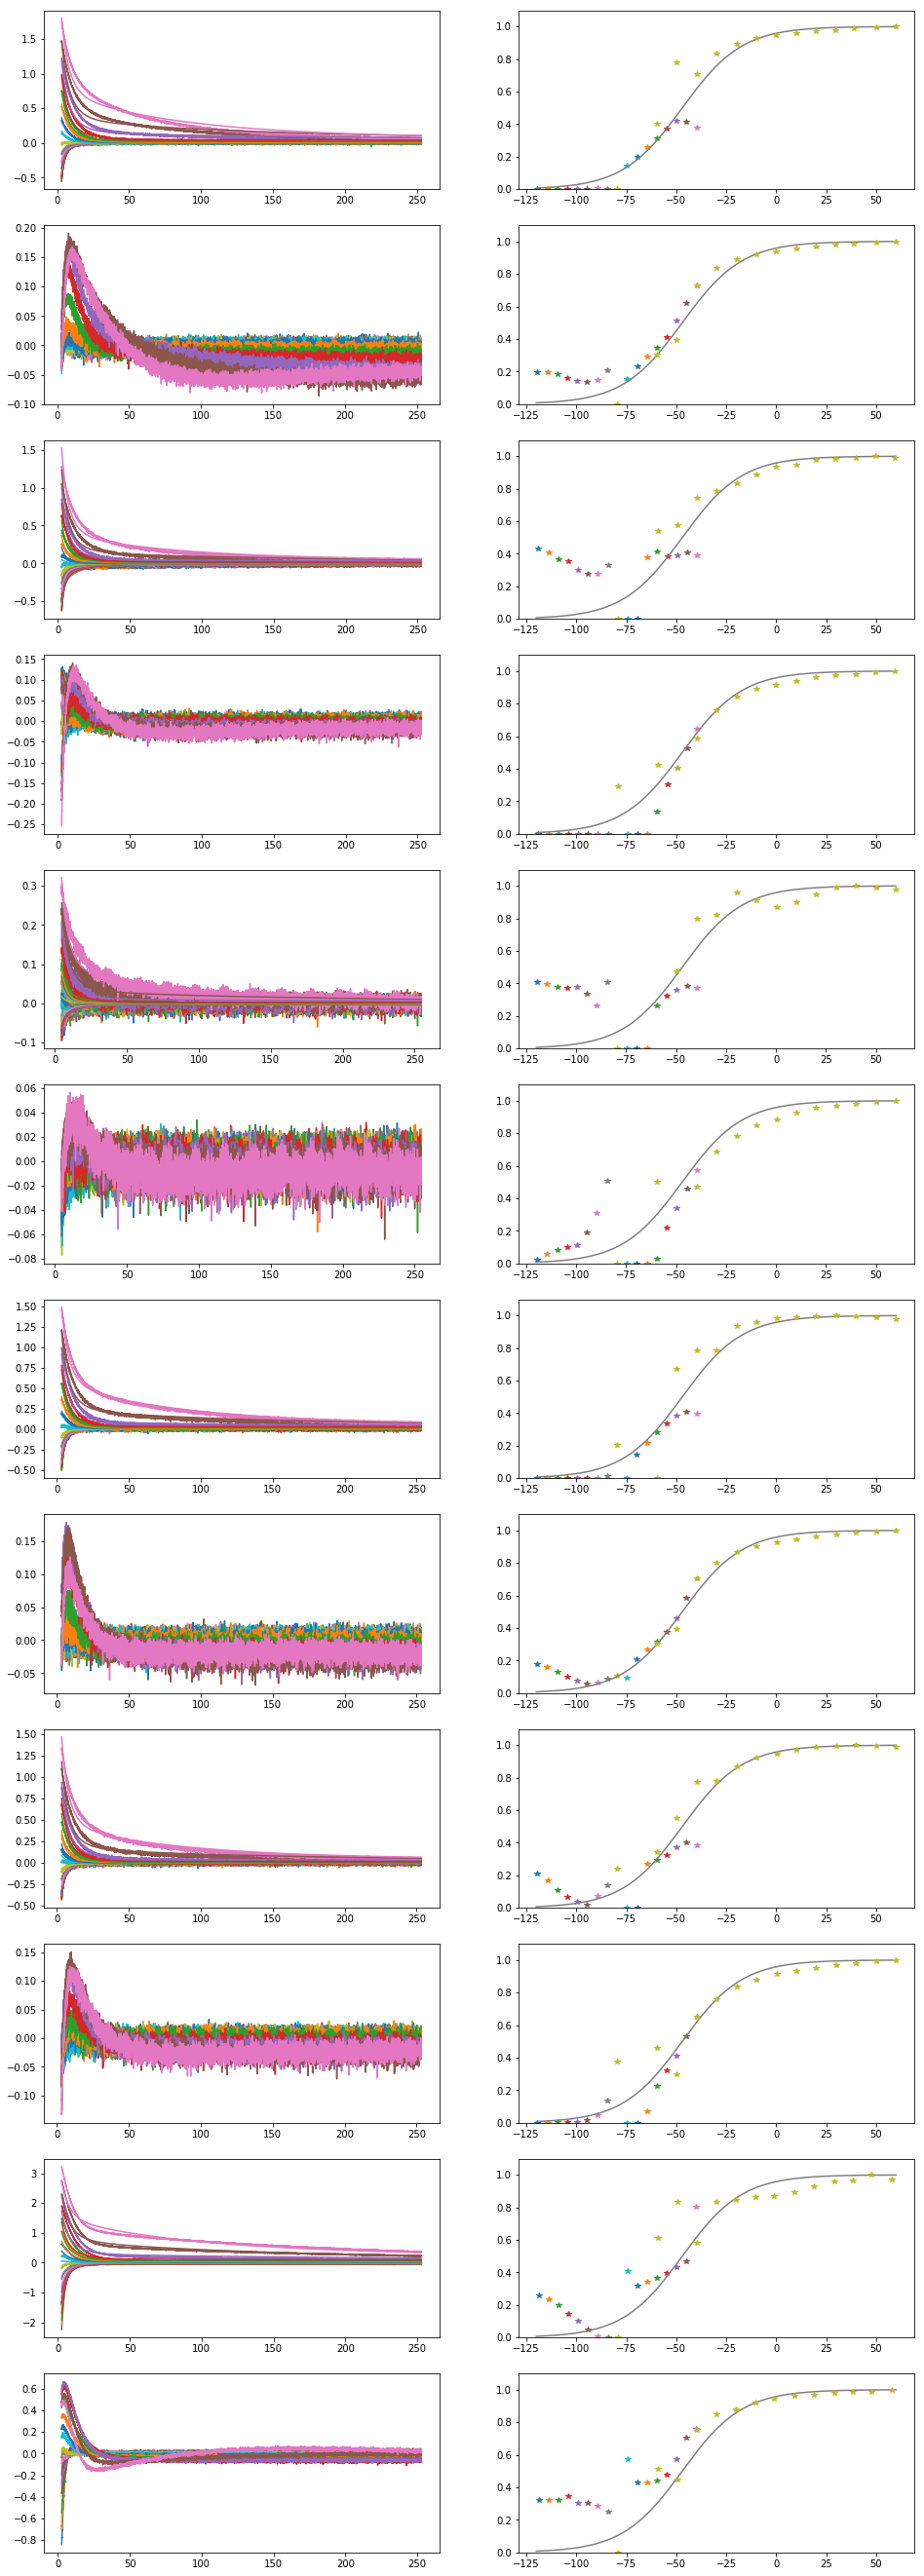

In [94]:
plt.figure(figsize=(16,8*len(ana)))
dur = 10000

def ninf_guess(V):
    nsinf = sigmoid(ns_p0, V)
    nfinf = sigmoid(nf_p0, V)
    return [nsinf, nfinf]
    
def state_fixedninf(t, V, state, ninf):
#     nsinf = sigmoid(ns_p0, V)
    nsinf = ninf[0]
    tauns = tau_model(tauns_p1, V)
    ns = nsinf - (nsinf-state[0]) * np.exp(-t/tauns)

    hsinf = sigmoid_min(hs_p0, V)
    tauhs = taui_model(tauhs_p0, V)
    hs = hsinf - (hsinf-state[1]) * np.exp(-t/tauhs)
    
#     nfinf = sigmoid(nf_p0, V)
    nfinf = ninf[1]
    taunf = tau_model(taunf_p1, V)
    nf = nfinf - (nfinf-state[2]) * np.exp(-t/taunf)

    hfinf = sigmoid_min(hf_p0, V)
    tauhf = taui_model(tauhf_p0, V)
    hf = hfinf - (hfinf-state[3]) * np.exp(-t/tauhf)
    
    return (ns, hs, nf, hf)

def HH_state0_ninf(t, V, params, state0, ninf):
    state = state_fixedninf(t, V, state0, ninf)
    return (V - params['E_K']) * (params['gA_slow'] * state[0]**4 * state[1]
                                  + params['gA_fast'] * state[2]**4 * state[3])

ninffits_ns = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]
ninffits_nf = [[0 for x in range(len(ana[0].rec2.current))] for y in range(len(ana))]

mean_cost = 0.
for j,a in enumerate(ana):
    t0 = a.rec2.tail_cut
    t = np.arange(t0 - Kv14.rec2_limits[0], t0+dur - Kv14.rec2_limits[0]) * Kv14.tres
    sum_cost = 0.
    
    for current, tail_baseline in zip(a.rec2.current, a.rec2.tail_baseline):
        plt.subplot(2*len(ana),2,4*j+1)
        plt.plot(t, current[t0:t0+dur] - tail_baseline)
    plt.gca().set_prop_cycle(None)
    
    for i, current, voltage, tail_baseline in zip(range(len(a.rec2.current)),
                                                  a.rec2.current,
                                                  a.rec2.voltage,
                                                  a.rec2.tail_baseline):
        state_after_prepulse = state_at_1(Kv14.tres*(Kv14.rec2_limits[0]-Kv14.rec2_prepulse),
                                        np.median(voltage[Kv14.rec2_prepulse:Kv14.rec2_limits[0]]),
                                        (0,1,0,1))
        
        medV = tailV[j][i]
        exp_current = current[t0:t0+dur] - tail_baseline
        
        fit = scipy.optimize.least_squares(lambda p:
                   exp_current - HH_state0_ninf(t, medV, a.params, state_after_prepulse, p),
                                           ninf_guess(medV),
                                          bounds = ([0,0],[1,1]))
        sum_cost += fit.cost
        
        plt.subplot(2*len(ana),2,4*j+1)
        plt.plot(t, HH_state0_ninf(t, medV, a.params, state_after_prepulse, fit.x))
        
        plt.subplot(2*len(ana),2,4*j+3)
        plt.plot(t, exp_current - HH_state0_ninf(t, medV, a.params, state_after_prepulse, fit.x))
    
        plt.subplot(2*len(ana),2,4*j+2)
        plt.plot(medV, fit.x[0], '*')
    
        plt.subplot(2*len(ana),2,4*j+4)
        plt.plot(medV, fit.x[1], '*')
        
        ninffits_ns[j][i] = fit.x[0]
        ninffits_nf[j][i] = fit.x[1]
    
    Vprobe = np.arange(-120, 60, 0.1)
    ninfprobe = ninf_guess(Vprobe)
    
    ret, V_ = zip(*allfits_ext[j])
    params = [r.x for r in ret]
    V_ += a.params['E_K']
    ns_ = [(el[0] / a.params['gA_slow'])**0.25 for el in params]
    nf_ = [(el[4] / a.params['gA_fast'])**0.25 for el in params]
    
    plt.subplot(2*len(ana),2,4*j+2)
    plt.plot(Vprobe, ninfprobe[0])
    plt.plot(V_, ns_, '*')
    plt.ylim(0,1.1)
    
    plt.subplot(2*len(ana),2,4*j+4)
    plt.plot(Vprobe, ninfprobe[1])
    plt.plot(V_, nf_, '*')
    plt.ylim(0,1.1)
    
    cost = sum_cost/len(a.rec2.current)
    mean_cost += cost
    print cost
print
print mean_cost/len(ana)

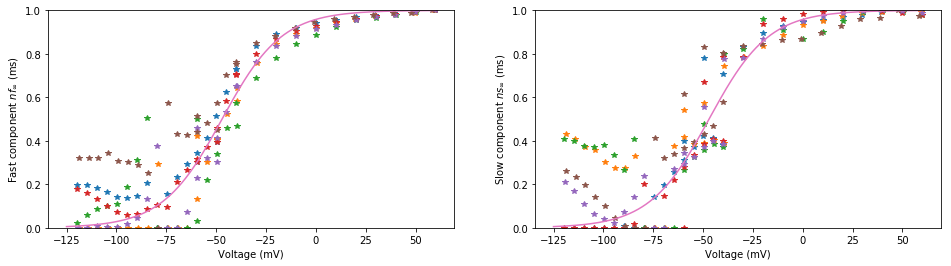

In [101]:
plt.figure(figsize=(16,4))

for nf, ns, V, fext, a in zip(ninffits_nf, ninffits_ns, tailV, allfits_ext, ana):
    ret, V_ = zip(*fext)
    params = [r.x for r in ret]
    V_ += a.params['E_K']
    ns_ = [(el[0] / a.params['gA_slow'])**0.25 for el in params]
    nf_ = [(el[4] / a.params['gA_fast'])**0.25 for el in params]
    
    V = np.concatenate((V,V_))
    
    plt.subplot(1,2,1)
    plt.plot(V, np.concatenate((nf, nf_)), '*')
    
    plt.subplot(1,2,2)
    plt.plot(V, np.concatenate((ns, ns_)), '*')

Vprobe = np.arange(-125,60,0.1)
nprobe = ninf_guess(Vprobe)

plt.subplot(1,2,1)
plt.plot(Vprobe, nprobe[1])
plt.ylim(0, 1)
plt.ylabel('Fast component $nf_\infty$ (ms)')
plt.xlabel('Voltage (mV)')

plt.subplot(1,2,2)
plt.plot(Vprobe, nprobe[0])
plt.ylim(0, 1);
plt.ylabel('Slow component $ns_\infty$ (ms)')
plt.xlabel('Voltage (mV)')

plt.savefig('/home/kernfel/Documents/Thesis/Models figures/Kv14-ninf.svg')